# Observable 4

En este notebook se describen los análisis realizados sobre los espacios de parametros derivados del observable 4.


* esp 1: $\dfrac{\rho^{450}_{max}}{\sqrt{S_{rad}}}$ y $X^{Rd}_{max}$


* esp 2: $\dfrac{\rho^{450}_{max}}{X^{Rd}_{max} \cdot \sqrt{S_{rad}}}$ y E$_{true}$


* esp 3: $\rho^{450}_{\mu}$, $X^{Rd}_{max}$ y $\sqrt{S_{rad}}$


* esp 4: $\rho^{450}_{\mu}$, $X^{Rd}_{max}$, $\sqrt{S_{rad}}$ y E$_{true}$


* esp 3: $\rho^{450}_{\mu}$, $X^{Rd}_{max}$, $\sqrt{S_{rad}}$, E$_{true}$ y $\theta$


* esp 3: $\rho^{450}_{\mu}$, $X^{Rd}_{max}$, $\sqrt{S_{rad}}$, E$_{true}$, $\theta$ y estaciones de radio.

In [1]:
#Librerias importantes
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt
from scipy.stats import norm


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, accuracy_score, balanced_accuracy_score,precision_recall_curve, roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn import svm
import os

In [2]:
def MeritFactor(v1, v2):
    #Calculo de MF
    muF, stdF = norm.fit(v1)
    muP, stdP = norm.fit(v2)
    #muF, stdF = np.mean(v1), np.std(v1)
    #muP, stdP = np.mean(v2), np.std(v2)
    MF = np.abs(muF - muP) / (np.sqrt(pow(stdF,2) + pow(stdP,2)))
    return MF

In [3]:
def boostMF(v1, v2):
    vv=[]
    size=int(len(v1))
    for i in range(20000):
        #np.random.seed(seed=None)
        samplexF = np.random.choice(v1, size=int(size*0.90), replace=True)
        samplexP = np.random.choice(v2, size=int(size*0.90), replace=True)
        MF = MeritFactor(np.array(samplexP), np.array(samplexF))
        vv.append(np.abs(MF))
    
    avg, std = norm.fit(vv)
    return "%.2f"%avg, "%.2f"%std

In [4]:
# To plot pretty figures
import matplotlib as mpl
mpl.rc('axes', labelsize=22)
mpl.rc('xtick', labelsize=20)
mpl.rc('ytick', labelsize=20)

# Where to save the figures
PROJECT_ROOT_DIR = "/home/csarmiento/MEGA/phd_mega/analisisDeDatos/ML_MassComp/"
#CHAPTER_ID = "05_ModelosLineales"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "plots")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=500):
    os.makedirs(IMAGES_PATH, exist_ok=True)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, figsize=(10,8))

In [5]:
#Función para calcular el accuracy
def accuracy(X, y, model):
    a=accuracy_score(y, model.predict(X))
    return a

In [6]:
#Función para calcular el accuracy via Cross-Val score
#Esto nos sirve para validar nuestro modelo sin usar los datos de test
def crossAccuracy(X, y, model):
    scoresGauTrain= cross_val_score(model, X, y, cv=10, scoring="accuracy");
    pres = cross_val_score(model, X, y, cv=10, scoring="precision");
    recl = cross_val_score(model, X, y, cv=10, scoring="recall");
    F1 = 2/((1/pres)+(1/recl))
    print("Accuracy: ", scoresGauTrain.mean(), scoresGauTrain.std())
    print("presicion: ", pres.mean(), pres.std())
    print("recall: ", recl.mean(), recl.std())
    print("F1_score: ", F1.mean(), F1.std())

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve

def auc_cv(X, y, model):
    model = model
    X = np.array(X)
    y = np.array(y)
    random_state = np.random.RandomState(369)

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=10)

    tprs = []
    for i, (train, train) in enumerate(cv.split(X, y)):
        viz = roc_auc_score(y[train], model.predict_proba(X[train])[:, 1])
        tprs.append(viz)

    print(np.mean(tprs), np.std(tprs))

In [8]:
"""
Matriz de Confusion
Con MC podemos ver en detalle el comportamiento del modelo y saber cuantos eventos fueron mal clasificados.
Esta podría ser una mirada más realista que el accuracy.

>>> La precisión es definida como el ratio entre verdaderos positivos y número total 
de positivos predichos. Esto nos dice la fracción de los eventos que el modelo nos 
dice que son de la clase, realmente lo son.

>>> El recall o exhaustividad es definida como el es el ratio entre los verdaderos positivos 
y la suma de los verdaderos positivos y los falsos negativos. Esto nos dice la fracción
de los elementos de la clase encontró.
"""
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
def mconfusion(X, y, model):
    aux_pred = cross_val_predict(model, X, y, cv=10)
    cm = confusion_matrix(y, aux_pred)
    tp = cm[1, 1]
    fp = cm[0, 1]
    fn = cm[1, 0]
    pres=tp/(tp + fp)
    exha=tp/(tp + fn)
    print("Matriz de confusión, \n"), print(cm), print("precisión: ", pres), print("exhaustividad: ", exha)

In [9]:
#Funcion para calcular la energia con GeoCeLDF
def GeoCeEnergy(RadEnergy, Alpha):
    d = 2.3137 * 1e14   #energy calibration parameters from Aab et al., PRD 93, 122005 (2016)
    c = 0.505
    E = d * pow(RadEnergy / ( np.sin((np.pi/180)*Alpha) * np.sin((np.pi/180)*Alpha)), c)
    #return list(E)
    return np.array(E)
 
def GeoCeEnergyError(RadEnergy, RadEnergyError, Alpha):
    c = 0.505   #energy calibration parameters from Aab et al., PRD 93, 122005 (2016)
    errorE = pow(1 / ( np.sin((np.pi/180)*Alpha) * np.sin((np.pi/180)*Alpha)), c) * pow(RadEnergy, c - 1) * RadEnergyError
    return errorE

In [10]:
#A partir de aquí python sabe en que carpeta se encuentran los datos
os.chdir("/home/csarmiento/MEGA/phd_mega/XmaxAnalysis/AnalisisXmax/newData/")
os.getcwd()

'/home/csarmiento/MEGA/phd_mega/XmaxAnalysis/AnalisisXmax/newData'

In [11]:
#Cargando datos
df= pd.read_csv(r"CutEvents_IronRefDist_Sd140_Filter_MdRd_e.txt", delimiter="\t")
dp= pd.read_csv(r"CutEvents_ProtonRefDist_Sd140_Filter_MdRd_e.txt", delimiter="\t")

In [12]:
print(df.shape, dp.shape)

(305, 59) (305, 59)


In [13]:
#angulo alfa
AlphaFe=df['lorentz angle']
AlphaFe=np.array(AlphaFe)
AlphaPr=dp['lorentz angle']
AlphaPr=np.array(AlphaPr)

#radiation energy
RadEGeoCeFe=df['GeoCe Erad']
RadEGeoCeFe=np.array(RadEGeoCeFe)
RadEGeoCePr=dp['GeoCe Erad']
RadEGeoCePr=np.array(RadEGeoCePr)

#radiation energy error
RadEGeoCeFe_err=df['GeoCe Erad Error']
RadEGeoCeFe_err=np.array(RadEGeoCeFe_err)
RadEGeoCePr_err=dp['GeoCe Erad Error']
RadEGeoCePr_err=np.array(RadEGeoCePr_err)

#Energia Rd
GeoCeEnergyFe=GeoCeEnergy(RadEGeoCeFe,AlphaFe)
GeoCeEnergyFe_err=GeoCeEnergyError(RadEGeoCeFe, RadEGeoCeFe_err, AlphaFe)
GeoCeEnergyPr=GeoCeEnergy(RadEGeoCePr,AlphaPr)
GeoCeEnergyPr_err=GeoCeEnergyError(RadEGeoCePr,RadEGeoCePr_err, AlphaPr)

df["EnergyRd"] = GeoCeEnergyFe
dp["EnergyRd"] = GeoCeEnergyPr

In [14]:
#Inclusion del target

df["Mu_rootSrad"] = df["N_mu_ref"]/np.sqrt(df["GeoCe Erad"])
dp["Mu_rootSrad"] = dp["N_mu_ref"]/np.sqrt(dp["GeoCe Erad"])

df["rootSrad"] = np.sqrt(df["GeoCe Erad"])
dp["rootSrad"] = np.sqrt(dp["GeoCe Erad"])

df["Mu_rootSrad_Xmax"] = df["N_mu_ref"]/(np.sqrt(df["GeoCe Erad"]) * df["GeoCeXmax"])
dp["Mu_rootSrad_Xmax"] = dp["N_mu_ref"]/(np.sqrt(dp["GeoCe Erad"]) * dp["GeoCeXmax"])

df["target"] = df["Rd rec success"]
dp["target"] = dp["Rd rec success"]*0

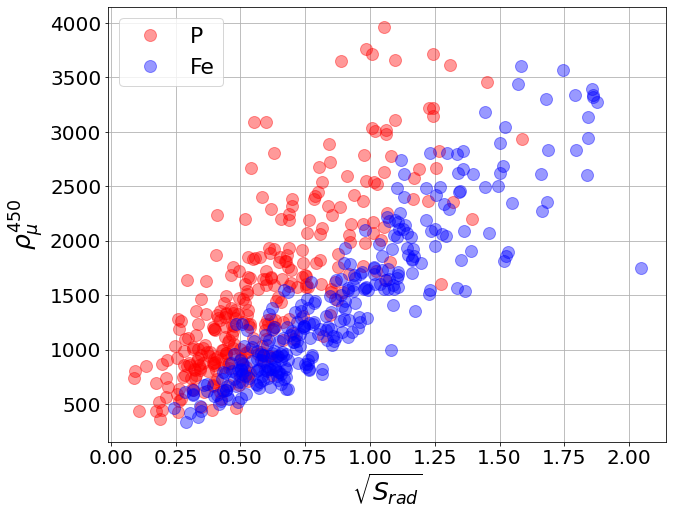

In [15]:
plt.figure(figsize=(10, 8))
plt.plot(dp['N_mu_ref'], np.sqrt(dp["GeoCe Erad"]), 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(df['N_mu_ref'], np.sqrt(df["GeoCe Erad"]), 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$\sqrt{S_{rad}}$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()
plt.show()

<AxesSubplot:>

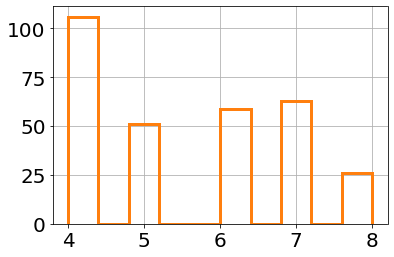

In [16]:
#Iron
df["Energy_cut"] = pd.cut(df["MC energy"],
                               bins=[0.1E18, 0.35E18, 0.45E18, 0.6E18, 0.9E18, np.inf],
                               labels=[4, 5, 6, 7, 8])

df["Energy_cut"].hist(histtype='step',linewidth=3, label="Antenas")

#Proton

dp["Energy_cut"] = pd.cut(dp["MC energy"],
                               bins=[0.1E18, 0.35E18, 0.45E18, 0.6E18, 0.9E18, np.inf],
                               labels=[4, 5, 6, 7, 8])

dp["Energy_cut"].hist(histtype='step',linewidth=3, label="Energy")

In [17]:
df["Energy_cut"].value_counts()

4    106
7     63
6     59
5     51
8     26
Name: Energy_cut, dtype: int64

In [18]:
#### Iron

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=224466)
for train_index, test_index in split.split(df, df["Energy_cut"]):
    train_set_fe = df.loc[train_index]
    test_set_fe = df.loc[test_index]
    
train_set_fe=train_set_fe.drop(["Energy_cut"], axis=1)
test_set_fe=test_set_fe.drop(["Energy_cut"], axis=1)
print(train_set_fe.shape, test_set_fe.shape)

(244, 64) (61, 64)


In [19]:
#### Proton

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=445543)
for train_index, test_index in split.split(dp, dp["Energy_cut"]):
    train_set_pr = dp.loc[train_index]
    test_set_pr = dp.loc[test_index]
    
train_set_pr=train_set_pr.drop(["Energy_cut"], axis=1)
test_set_pr=test_set_pr.drop(["Energy_cut"], axis=1)
print(train_set_pr.shape, test_set_pr.shape)

(244, 64) (61, 64)


In [20]:
### Contanetando data set
f_train = [train_set_fe, train_set_pr]
f_test = [test_set_fe, test_set_pr]

df_train_ = pd.concat(f_train)
df_test_ = pd.concat(f_test)

print(df_train_.shape, df_test_.shape)
df_train_.head()

(488, 64) (122, 64)


,runnr,MC energy,MC zenith,MC azimuth,MC Xmax,MC core x,MC core y,MC core z,Sd rec success,Sd energy,...,MLDF Likelihood,M beta,M beta error,M beta syst,pvalueMd,EnergyRd,Mu_rootSrad,rootSrad,Mu_rootSrad_Xmax,target
246,104205,3.824250e+17,50.0277,332.231,606.878,449654,6113980.0,1468.62,1,3.718930e+17,...,10.3269,0.625931,0.309216,0,0.342569,2.963127e+17,0.000717,1186.642322,1.174137e-06,1
76,101420,7.590210e+17,50.6696,252.789,615.647,448851,6114320.0,1478.28,1,5.112060e+17,...,17.2197,0.964079,0.189909,0,0.304324,5.784101e+17,0.000495,2251.384019,7.380244e-07,1
171,102730,6.116010e+17,40.6307,285.853,616.988,449204,6114370.0,1473.42,1,4.199210e+17,...,17.0630,0.588354,0.280413,0,0.328039,4.665071e+17,0.000614,1867.359098,9.178258e-07,1
191,103178,3.842740e+17,53.6568,218.822,601.143,450980,6114150.0,1460.45,1,2.665860e+17,...,10.9482,0.000097,2.893310,0,0.445807,3.314039e+17,0.000461,1327.143549,8.079305e-07,1
75,101416,9.452550e+17,49.0955,355.084,636.076,449628,6113950.0,1467.00,1,6.682260e+17,...,10.3834,1.490790,0.183751,0,0.765089,7.529746e+17,0.000438,2809.946619,7.318278e-07,1


In [21]:
df_train = df_train_.copy()
df_test = df_test_.copy()

In [22]:
#Features

df_train_1 = df_train[["GeoCeXmax", "Mu_rootSrad", "target"]]
df_test_1 = df_test[["GeoCeXmax", "Mu_rootSrad", "target"]]

In [23]:
print(df_train_.shape, df_test_.shape)

(488, 64) (122, 64)


In [24]:
df_train_1.head()

,GeoCeXmax,Mu_rootSrad,target
246,610.506,0.000717,1
76,670.556,0.000495,1
171,669.154,0.000614,1
191,571.015,0.000461,1
75,599.145,0.000438,1


In [25]:
corr_matrix = df_train_1.corr()
corr_matrix["target"].sort_values(ascending=False)

target         1.000000
Mu_rootSrad    0.652022
GeoCeXmax     -0.461443
Name: target, dtype: float64

In [26]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_1.drop("target", axis=1) 
df_train_labels = df_train_1["target"].copy()

df_test_aux = df_test_1.drop("target", axis=1) 
df_test_labels = df_test_1["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 2) (488,) (488, 2) (122,)


In [27]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [28]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [29]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [30]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 2) (122, 2) (488,) (122,)


In [31]:
X_train.head()

,GeoCeXmax,Mu_rootSrad
0,-0.751797,1.017026
1,0.260940,-0.177543
2,0.238489,0.492047
3,-1.481640,-0.380284
4,-0.956135,-0.522815


In [32]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

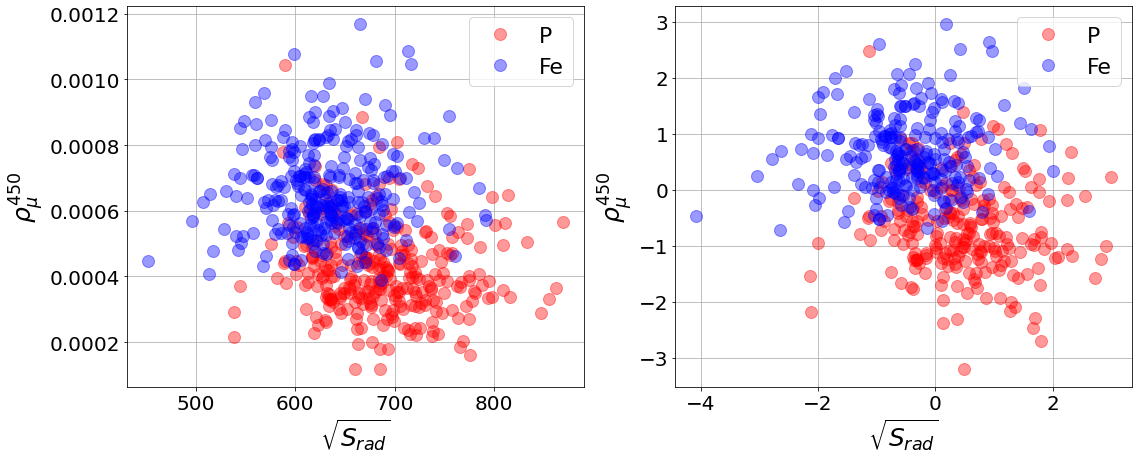

In [33]:
plt.figure(figsize=(18, 7))


plt.subplot(121)
plt.plot(dp["GeoCeXmax"], dp['Mu_rootSrad'], 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(df["GeoCeXmax"], df['Mu_rootSrad'], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$ \sqrt{S_{rad}}$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()

plt.subplot(122)
plt.plot(XX[yy==0, 0], XX[yy==0, 1], 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(XX[yy==1, 0], XX[yy==1, 1], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$ \sqrt{S_{rad}}$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()

In [34]:
def escala(method):
    
    Xss=XX
    y=yy

    plt.figure(figsize=(18, 22))

    plt.subplot(321)
    plt.plot(dp["GeoCeXmax"], dp['Mu_rootSrad'], 'o', alpha=0.4, markersize=12, color="r", label="P")
    plt.plot(df["GeoCeXmax"], df['Mu_rootSrad'], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
    plt.xlabel(r"$\sqrt{S_{rad}}$", fontsize=25)
    plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
    #plt.text(480, 0.0011, "(a)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()

    plt.subplot(322)
    plt.plot(Xss[y==0, 0], Xss[y==0, 1], 'o', alpha=0.4, markersize=12, color="r", label="P")
    plt.plot(Xss[y==1, 0], Xss[y==1, 1], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
    plt.xlabel(r"$\sqrt{S_{rad}}^*$", fontsize=25)
    #plt.text(-2.5, 2.5, "(b)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()

    plt.subplot(323)
    bins = np.linspace(500, 1100, 25)
    plt.hist(dp["GeoCeXmax"], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(df["GeoCeXmax"], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\sqrt{S_{rad}}$", fontsize=25)
    #plt.text(500, 65, "(c)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()    
    
    
    plt.subplot(324)
    bins = np.linspace(-4, 4, 25)
    plt.hist(Xss[y==0, 0], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(Xss[y==1, 0], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\sqrt{S_{rad}}^*$", fontsize=25)
    #plt.text(-2.5, 45, "(d)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()
    
    plt.subplot(325)
    bins = np.linspace(0, 12E-4, 20)
    plt.hist(dp['Mu_rootSrad'], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(df['Mu_rootSrad'], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\rho^{450}_{\mu}$", fontsize=25)
    plt.legend(fontsize=22)
    #plt.text(1.2E-4, 65, "(e)", c='k', fontsize=35)
    plt.grid()
    
    plt.subplot(326)
    bins = np.linspace(-4, 4, 18)
    plt.hist(Xss[y==0, 1], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(Xss[y==1, 1], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\rho^{450*}_{\mu}$", fontsize=25)
    #plt.text(-2.5, 47.5, "(f)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()
    

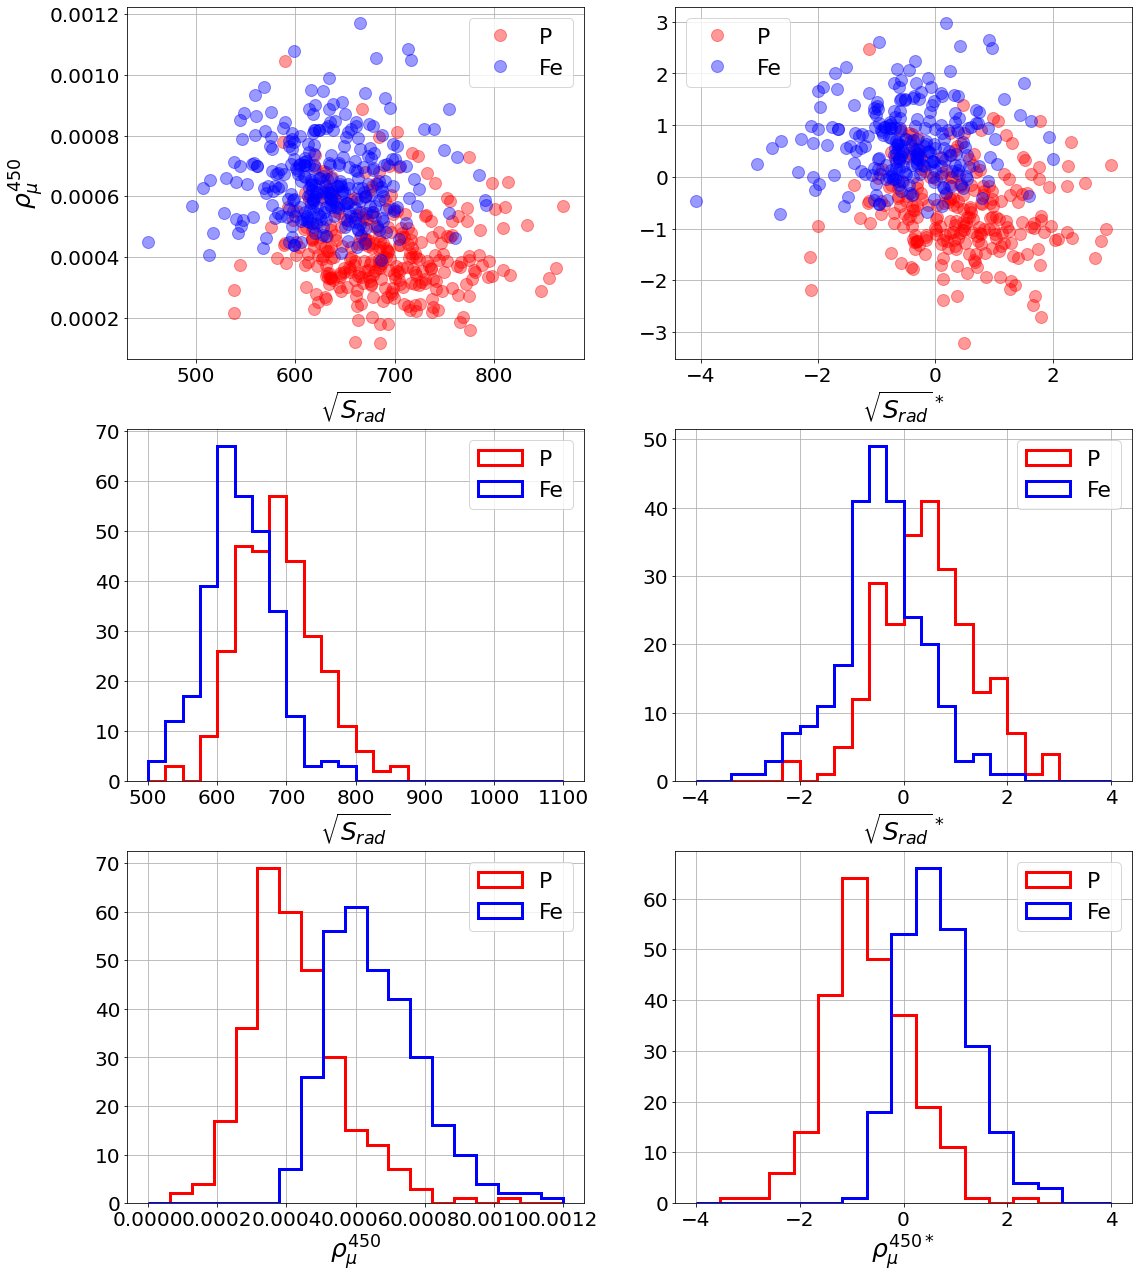

In [35]:
escala(PowerTransformer(method='box-cox'))


In [36]:
import sklearn.preprocessing as pp
from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [37]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.01, 100)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=300, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [38]:
model_Log_1 = rnd_search_cv.best_estimator_
model_Log_1

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=0.6165804367853311, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [39]:
print(accuracy(X_train, y_train, model_Log_1))
print(crossAccuracy(X_train, y_train, model_Log_1))

0.8504098360655737
Accuracy:  0.8482993197278912 0.048377105132342293
presicion:  0.8406662231073172 0.05319820125583832
recall:  0.8638333333333332 0.09332157664048904
F1_score:  0.8488689847001595 0.05454952001096342
None


In [40]:
mconfusion(X_train, y_train, model_Log_1)

Matriz de confusión, 

[[203  41]
 [ 33 211]]
precisión:  0.8373015873015873
exhaustividad:  0.8647540983606558


In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_1.predict(X_train)))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85       244
           1       0.84      0.87      0.85       244

    accuracy                           0.85       488
   macro avg       0.85      0.85      0.85       488
weighted avg       0.85      0.85      0.85       488



In [42]:
ypred = cross_val_predict(model_Log_1, X_train, y_train, cv=5, method="decision_function")

In [43]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

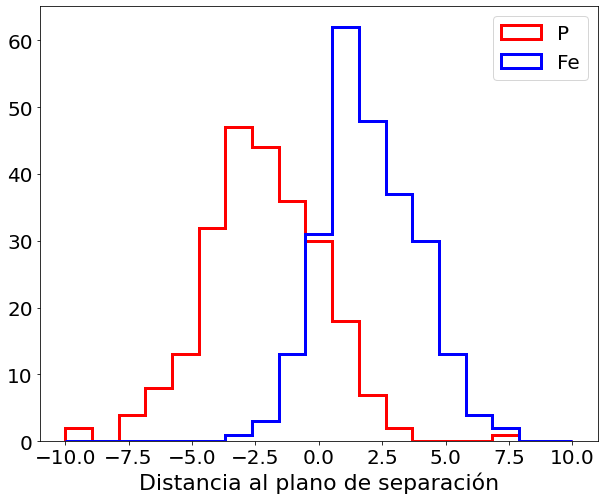

In [44]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [45]:
boostMF(c1_pred, c2_pred)

('1.43', '0.09')

In [46]:
lr=model_Log_1.named_steps['logi_clf']

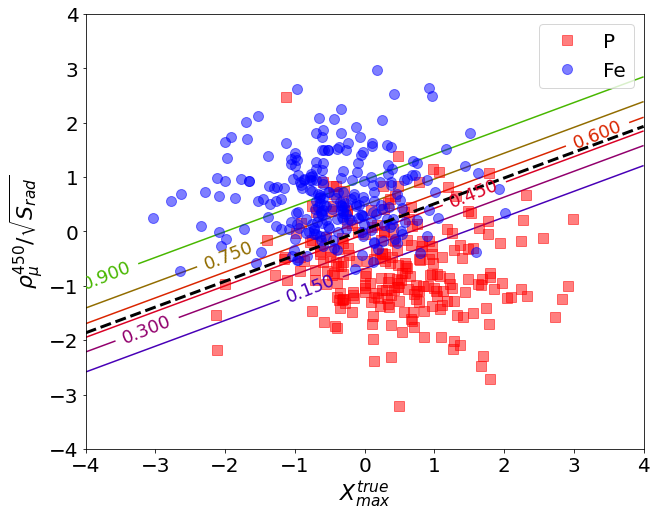

In [47]:
X=X_train
y=y_train

log_reg = model_Log_1.named_steps['logi_clf']

x0, x1 = np.meshgrid(
        np.linspace(-4, 4, 500).reshape(-1, 1),
        np.linspace(-4, 4, 500).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 8))
plt.plot(XX[yy==0, 0], XX[yy==0, 1], "rs", markersize=10, alpha=0.5, label="P")
plt.plot(XX[yy==1, 0], XX[yy==1, 1], "bo", markersize=10, alpha=0.5, label="Fe")

plt.legend(fontsize=20)

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)

left_right = np.array([-4, 4])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=18)
plt.plot(left_right, boundary, "k--", linewidth=3)
#plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
#plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel(r"$X^{true}_{max}$", fontsize=22)
plt.ylabel(r"$\rho^{450}_{\mu} / \sqrt{S_{rad}}$", fontsize=22)
plt.axis([-4, 4, -4, 4])
#save_fig("plano_reglog_plot")
plt.show()

In [48]:
from sklearn.preprocessing import PolynomialFeatures

In [49]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 9)

In [50]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 9)

In [51]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.01, 100)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [52]:
model_Log_2 = rnd_search_cv.best_estimator_
model_Log_2

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=6.265548969583746, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [53]:
print(accuracy(X_poly2, y_train, model_Log_2))
print(crossAccuracy(X_poly2, y_train, model_Log_2))

0.8545081967213115
Accuracy:  0.8523809523809524 0.04605900923202729
presicion:  0.8355794866657419 0.04548411284053417
recall:  0.8805000000000002 0.0861073296660756
F1_score:  0.8550308569690834 0.05047689239515508
None


In [54]:
mconfusion(X_poly2, y_train, model_Log_2)

Matriz de confusión, 

[[201  43]
 [ 29 215]]
precisión:  0.8333333333333334
exhaustividad:  0.8811475409836066


In [55]:
print(classification_report(y_train, model_Log_2.predict(X_poly2)))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85       244
           1       0.83      0.89      0.86       244

    accuracy                           0.85       488
   macro avg       0.86      0.85      0.85       488
weighted avg       0.86      0.85      0.85       488



In [56]:
ypred = cross_val_predict(model_Log_2, X_poly2, y_train, cv=5, method="decision_function")

In [57]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

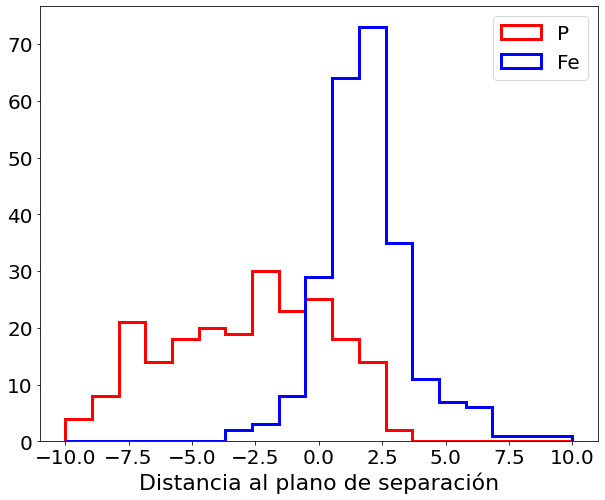

In [58]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [59]:
boostMF(c1_pred, c2_pred)

('0.82', '0.15')

## SVM

In [60]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [61]:
model_svm_1 = rnd_search_cv.best_estimator_
model_svm_1

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=3.7238068352510765, break_ties=False, cache_size=200,
                     class_weight=None, coef0=30.563811797620623,
                     decision_function_shape='ovr', degree=3,
                     gamma=1.1551771485333527e-05, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [62]:
print(accuracy(X_train, y_train, model_svm_1))
print(crossAccuracy(X_train, y_train, model_svm_1))

0.8504098360655737
Accuracy:  0.8462159863945578 0.049272074826398185
presicion:  0.8331234036079758 0.04497116924774866
recall:  0.8679999999999998 0.09464788546091363
F1_score:  0.8474736717183525 0.05596871244164518
None


In [63]:
mconfusion(X_train, y_train, model_svm_1)

Matriz de confusión, 

[[201  43]
 [ 32 212]]
precisión:  0.8313725490196079
exhaustividad:  0.8688524590163934


In [64]:
print(classification_report(y_train, model_svm_1.predict(X_train)))

              precision    recall  f1-score   support

           0       0.87      0.82      0.85       244
           1       0.83      0.88      0.85       244

    accuracy                           0.85       488
   macro avg       0.85      0.85      0.85       488
weighted avg       0.85      0.85      0.85       488



In [65]:
ypred = cross_val_predict(model_svm_1, X_train, y_train, cv=5, method="decision_function")

In [66]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

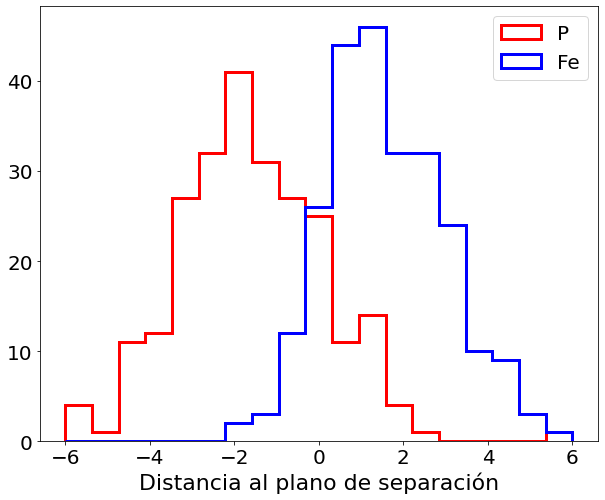

In [67]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [68]:
boostMF(c1_pred, c2_pred)

('1.43', '0.09')

In [69]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(0.01, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=10, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,


In [70]:
model_svm_1p = rnd_search_cv.best_estimator_
model_svm_1p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=66.12403149710897, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [71]:
print(accuracy(X_train, y_train, model_svm_1p))
print(crossAccuracy(X_train, y_train, model_svm_1p))

0.8401639344262295
Accuracy:  0.8422619047619048 0.04474114544570154
presicion:  0.7810401274249995 0.04810858736714178
recall:  0.9588333333333333 0.04930658058402436
F1_score:  0.8594296594448586 0.036227703827273375
None


In [72]:
mconfusion(X_train, y_train, model_svm_1p)

Matriz de confusión, 

[[177  67]
 [ 10 234]]
precisión:  0.7774086378737541
exhaustividad:  0.9590163934426229


In [73]:
print(classification_report(y_train, model_svm_1p.predict(X_train)))

              precision    recall  f1-score   support

           0       0.96      0.71      0.82       244
           1       0.77      0.97      0.86       244

    accuracy                           0.84       488
   macro avg       0.86      0.84      0.84       488
weighted avg       0.86      0.84      0.84       488



In [74]:
ypred = cross_val_predict(model_svm_1p, X_train, y_train, cv=5, method="decision_function")

In [75]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

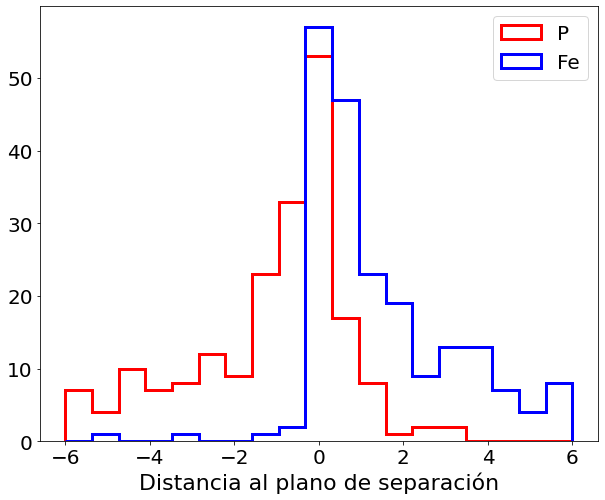

In [76]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [77]:
boostMF(c1_pred, c2_pred)

('0.65', '0.07')

In [78]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [79]:
model_svm_2 = rnd_search_cv.best_estimator_
model_svm_2

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=39.33358483806856, break_ties=False, cache_size=200,
                     class_weight=None, coef0=14.724344538488431,
                     decision_function_shape='ovr', degree=3,
                     gamma=5.2179532938638576e-05, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [80]:
print(accuracy(X_train, y_train, model_svm_2))
print(crossAccuracy(X_train, y_train, model_svm_2))

0.8504098360655737
Accuracy:  0.8565051020408163 0.056282384587620346
presicion:  0.8277615458783665 0.05818711248750981
recall:  0.9051666666666666 0.10043364310163537
F1_score:  0.8613252814260323 0.06156143495548508
None


In [81]:
mconfusion(X_train, y_train, model_svm_2)

Matriz de confusión, 

[[197  47]
 [ 23 221]]
precisión:  0.8246268656716418
exhaustividad:  0.9057377049180327


In [82]:
print(classification_report(y_train, model_svm_2.predict(X_train)))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       244
           1       0.83      0.89      0.86       244

    accuracy                           0.85       488
   macro avg       0.85      0.85      0.85       488
weighted avg       0.85      0.85      0.85       488



In [415]:
ypred = cross_val_predict(model_svm_2, X_train, y_train, cv=5, method="decision_function")

In [416]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

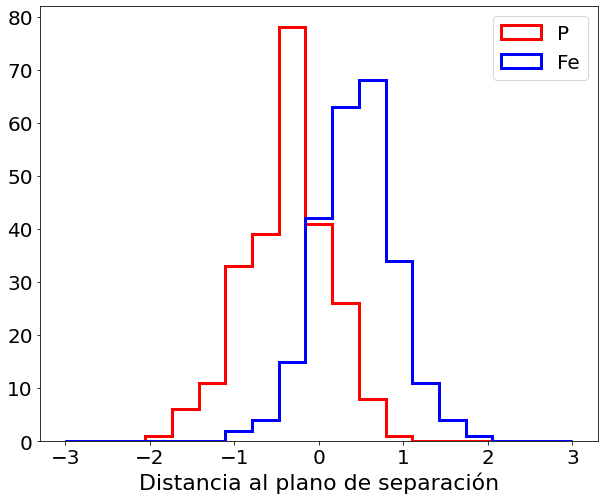

In [418]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-3, 3, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [86]:
boostMF(c1_pred, c2_pred)

('1.43', '0.08')

In [87]:
svcP=model_svm_2.named_steps['svm_clf']

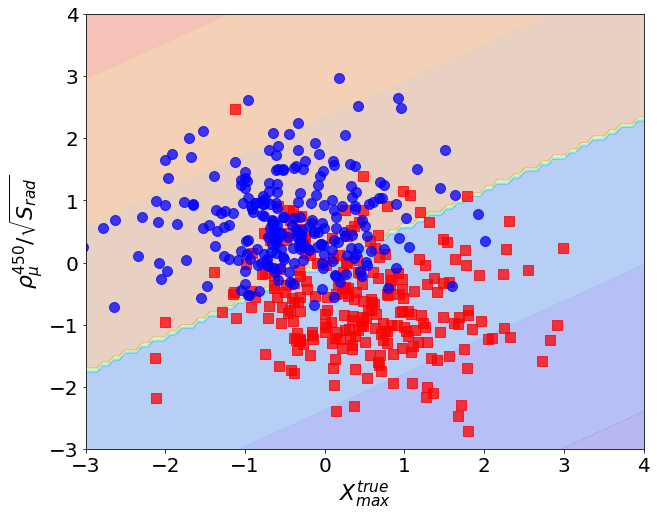

In [88]:
def plot_dataset(X, y, axes):
    plt.plot(XX[yy==0, 0], XX[yy==0, 1], "rs", markersize=10, alpha=0.75, label="P")
    plt.plot(XX[yy==1, 0], XX[yy==1, 1], "bo", markersize=10, alpha=0.75, label="Fe")

    #plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", markersize=10, alpha=0.75)
    #plt.plot(X[:, 0][y==1], X[:, 1][y==1], "ro", markersize=10, alpha=0.75)
    plt.axis(axes)
    #plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=22)
    plt.ylabel(r"$x_2$", fontsize=22, rotation=90)
    


#plot_dataset(X, y, [-6, 6, -1, 7])
#plot_dataset(XX, y, [-3, 4, -3, 7])
#plt.show()

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = model_svm_2.predict(X).reshape(x0.shape)
    y_decision = model_svm_2.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.jet, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.jet, alpha=0.1)

plt.figure(figsize=(10, 8))
plot_predictions(model_svm_2,[-3, 4, -3, 7])
plot_dataset(XX, y,[-3, 4, -3, 4])
plt.xlabel(r"$X^{true}_{max}$")
plt.ylabel(r"$\rho^{450}_{\mu} / \sqrt{S_{rad}}$")

plt.show()

## Incluyendo la energía

In [89]:
#Features

df_train_2 = df_train[["MC energy", "Mu_rootSrad_Xmax", "target"]]
df_test_2 = df_test[["MC energy", "Mu_rootSrad_Xmax", "target"]]

In [90]:
print(df_train_2.shape, df_test_.shape)

(488, 3) (122, 64)


In [91]:
df_train_2.head()

,MC energy,Mu_rootSrad_Xmax,target
246,3.824250e+17,1.174137e-06,1
76,7.590210e+17,7.380244e-07,1
171,6.116010e+17,9.178258e-07,1
191,3.842740e+17,8.079305e-07,1
75,9.452550e+17,7.318278e-07,1


In [92]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target              1.000000
Mu_rootSrad_Xmax    0.697060
MC energy          -0.005095
Name: target, dtype: float64

In [93]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 2) (488,) (488, 2) (122,)


In [94]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [95]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [96]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 2) (122, 2) (488,) (122,)


In [97]:
X_train.head()

,MC energy,Mu_rootSrad_Xmax
0,-0.324464,1.116677
1,1.092195,-0.237316
2,0.651643,0.361050
3,-0.314309,0.003477
4,1.534527,-0.259222


In [98]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

In [99]:
def escala(method):
    
    Xss=XX
    y=yy

    plt.figure(figsize=(18, 22))

    plt.subplot(321)
    plt.plot(np.sqrt(dp["GeoCe Erad"]), dp['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="r", label="P")
    plt.plot(np.sqrt(df["GeoCe Erad"]), df['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
    plt.xlabel(r"$\sqrt{S_{rad}}$", fontsize=25)
    plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
    #plt.text(480, 0.0011, "(a)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()

    plt.subplot(322)
    plt.plot(Xss[y==0, 0], Xss[y==0, 1], 'o', alpha=0.4, markersize=12, color="r", label="P")
    plt.plot(Xss[y==1, 0], Xss[y==1, 1], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
    plt.xlabel(r"$\sqrt{S_{rad}}^*$", fontsize=25)
    #plt.text(-2.5, 2.5, "(b)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()

    plt.subplot(323)
    bins = np.linspace(0, 12E3, 25)
    plt.hist(np.sqrt(dp["GeoCe Erad"]), bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(np.sqrt(df["GeoCe Erad"]), bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\sqrt{S_{rad}}$", fontsize=25)
    #plt.text(500, 65, "(c)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()    
    
    
    plt.subplot(324)
    bins = np.linspace(-4, 4, 25)
    plt.hist(Xss[y==0, 1], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(Xss[y==1, 1], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\sqrt{S_{rad}}^*$", fontsize=25)
    #plt.text(-2.5, 45, "(d)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()
    
    plt.subplot(325)
    bins = np.linspace(0, 4, 20)
    plt.hist(dp['N_mu_ref'], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(df['N_mu_ref'], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\rho^{450}_{\mu}$", fontsize=25)
    plt.legend(fontsize=22)
    #plt.text(1.2E-4, 65, "(e)", c='k', fontsize=35)
    plt.grid()
    
    plt.subplot(326)
    bins = np.linspace(-4, 4, 18)
    plt.hist(Xss[y==0, 0], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(Xss[y==1, 0], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\rho^{450*}_{\mu}$", fontsize=25)
    #plt.text(-2.5, 47.5, "(f)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()
    

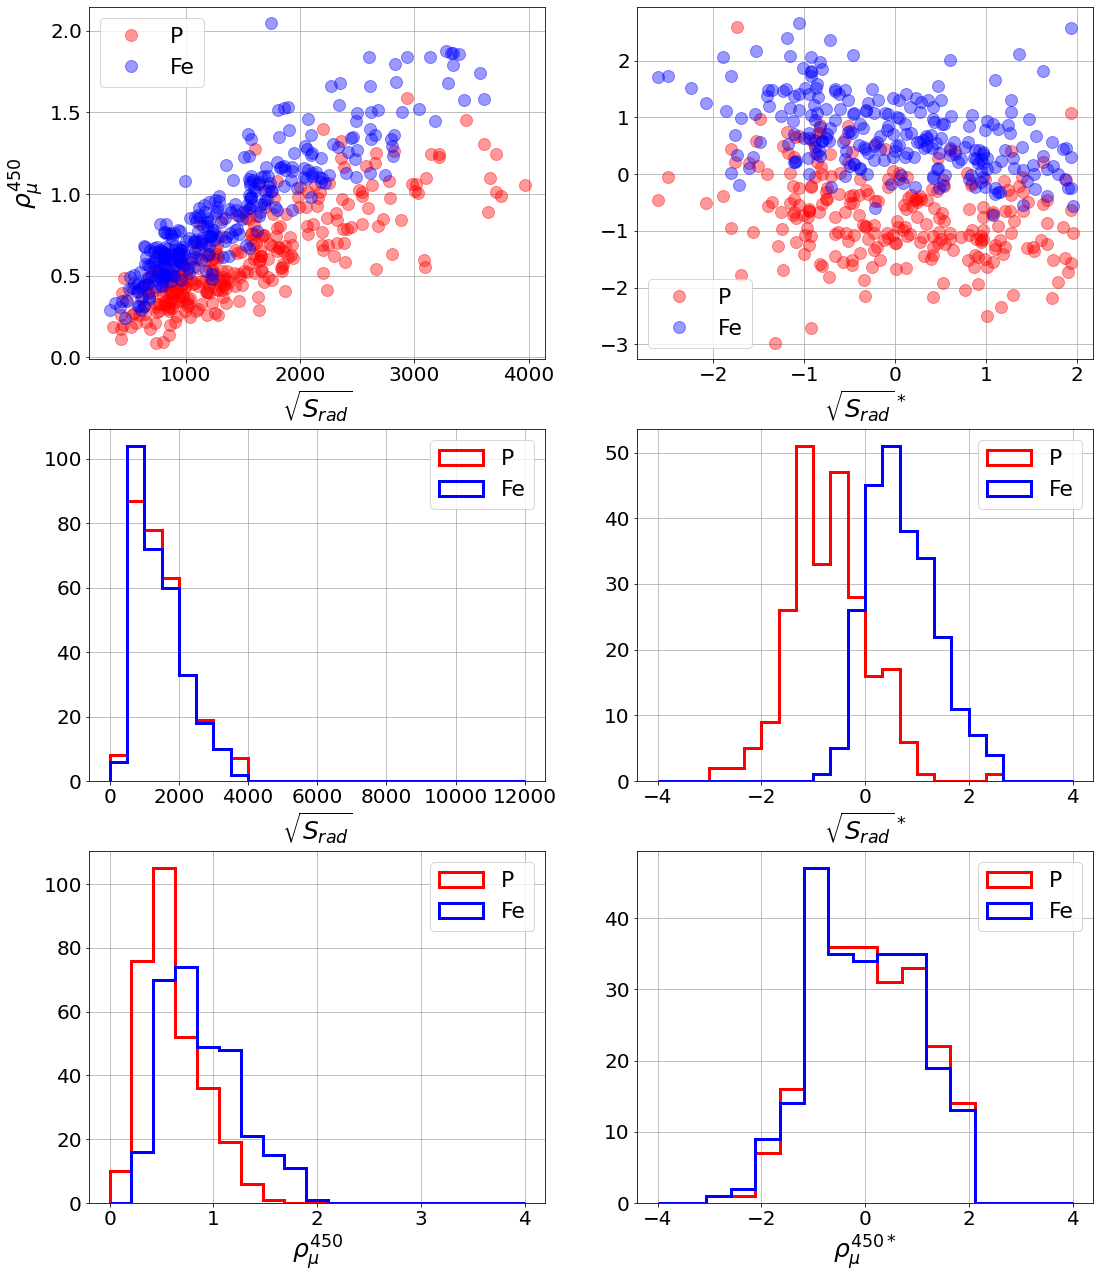

In [100]:
escala(PowerTransformer(method='box-cox'))

In [101]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=300, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [102]:
model_Log_3 = rnd_search_cv.best_estimator_
model_Log_3

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=97.07552196771536, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [103]:
print(accuracy(X_train, y_train, model_Log_3))
print(crossAccuracy(X_train, y_train, model_Log_3))

0.8586065573770492
Accuracy:  0.8605867346938775 0.05907154777169187
presicion:  0.8603891236200083 0.05534119343494735
recall:  0.8643333333333333 0.09675915116066973
F1_score:  0.8594626135786825 0.06539104236273892
None


In [104]:
mconfusion(X_train, y_train, model_Log_3)

Matriz de confusión, 

[[209  35]
 [ 33 211]]
precisión:  0.8577235772357723
exhaustividad:  0.8647540983606558


In [105]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_3.predict(X_train)))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       244
           1       0.86      0.86      0.86       244

    accuracy                           0.86       488
   macro avg       0.86      0.86      0.86       488
weighted avg       0.86      0.86      0.86       488



In [106]:
ypred = cross_val_predict(model_Log_3, X_train, y_train, cv=5, method="decision_function")

In [107]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

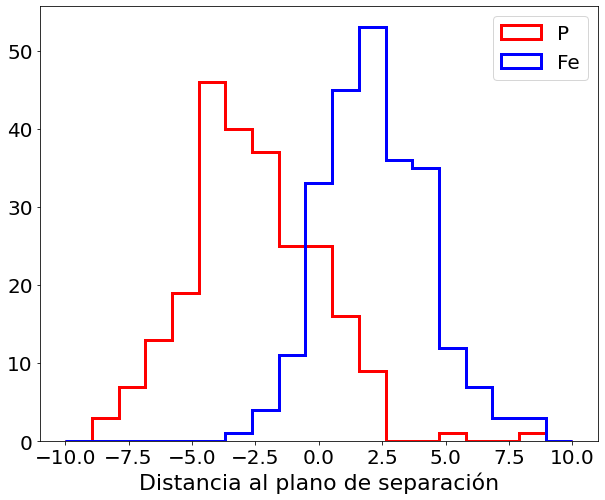

In [108]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [109]:
boostMF(c1_pred, c2_pred)

('1.50', '0.09')

In [110]:
log_reg=model_Log_3.named_steps['logi_clf']

In [111]:
print(log_reg.coef_[0][0])

0.9052318741259449


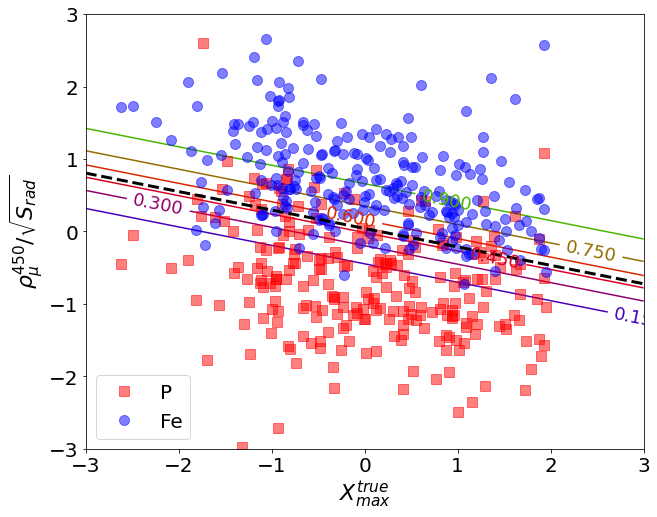

In [112]:
x0, x1 = np.meshgrid(
        np.linspace(-3, 3, 500).reshape(-1, 1),
        np.linspace(-3, 3, 500).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 8))
plt.plot(XX[yy==0, 0], XX[yy==0, 1], "rs", markersize=10, alpha=0.5, label="P")
plt.plot(XX[yy==1, 0], XX[yy==1, 1], "bo", markersize=10, alpha=0.5, label="Fe")

plt.legend(fontsize=20)

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)

left_right = np.array([-3, 3])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=18)
plt.plot(left_right, boundary, "k--", linewidth=3)
#plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
#plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel(r"$X^{true}_{max}$", fontsize=22)
plt.ylabel(r"$\rho^{450}_{\mu} / \sqrt{S_{rad}}$", fontsize=22)
plt.axis([-3, 3, -3, 3])
#save_fig("plano_reglog_plot")
plt.show()

In [113]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 9)

In [114]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 9)

In [115]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=10, cv=100, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=100, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                          

In [116]:
model_Log_4 = rnd_search_cv.best_estimator_
model_Log_4

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=40.84219643172299, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [117]:
print(accuracy(X_poly2, y_train, model_Log_4))
print(crossAccuracy(X_poly2, y_train, model_Log_4))

0.8647540983606558
Accuracy:  0.8523809523809524 0.05279982325744472
presicion:  0.8310120769108533 0.06005129938603723
recall:  0.893 0.0703238540215512
F1_score:  0.8585004474124333 0.04961224282707146
None


In [118]:
mconfusion(X_poly2, y_train, model_Log_4)

Matriz de confusión, 

[[198  46]
 [ 26 218]]
precisión:  0.8257575757575758
exhaustividad:  0.8934426229508197


In [119]:
print(classification_report(y_train, model_Log_4.predict(X_poly2)))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86       244
           1       0.84      0.91      0.87       244

    accuracy                           0.86       488
   macro avg       0.87      0.86      0.86       488
weighted avg       0.87      0.86      0.86       488



In [120]:
ypred = cross_val_predict(model_Log_4, X_poly2, y_train, cv=5, method="decision_function")

In [121]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

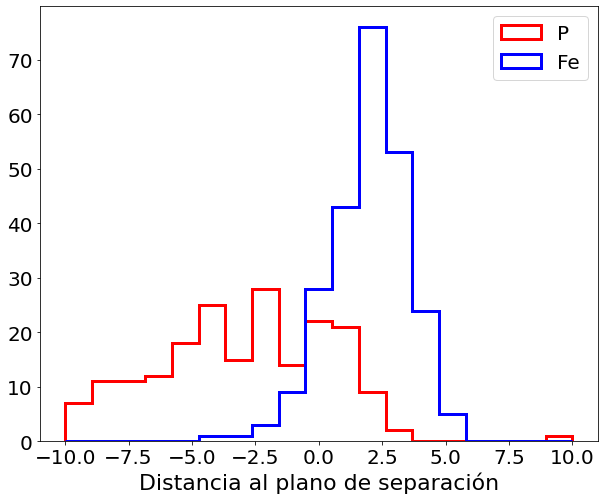

In [122]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [123]:
boostMF(c1_pred, c2_pred)

('0.79', '0.15')

## SVM

In [124]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [125]:
model_svm_3 = rnd_search_cv.best_estimator_
model_svm_3

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=0.9127097711772014, break_ties=False, cache_size=200,
                     class_weight=None, coef0=5.168643320698317,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.00015954149151451046, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [126]:
print(accuracy(X_train, y_train, model_svm_3))
print(crossAccuracy(X_train, y_train, model_svm_3))

0.8586065573770492
Accuracy:  0.8584608843537413 0.05287052622243913
presicion:  0.8395919540229885 0.047465750775616884
recall:  0.8889999999999999 0.08324395206593424
F1_score:  0.8617041383558744 0.05605086380250204
None


In [127]:
mconfusion(X_train, y_train, model_svm_3)

Matriz de confusión, 

[[202  42]
 [ 27 217]]
precisión:  0.8378378378378378
exhaustividad:  0.889344262295082


In [128]:
print(classification_report(y_train, model_svm_3.predict(X_train)))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85       244
           1       0.84      0.89      0.86       244

    accuracy                           0.86       488
   macro avg       0.86      0.86      0.86       488
weighted avg       0.86      0.86      0.86       488



In [129]:
ypred = cross_val_predict(model_svm_3, X_train, y_train, cv=5, method="decision_function")

In [130]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

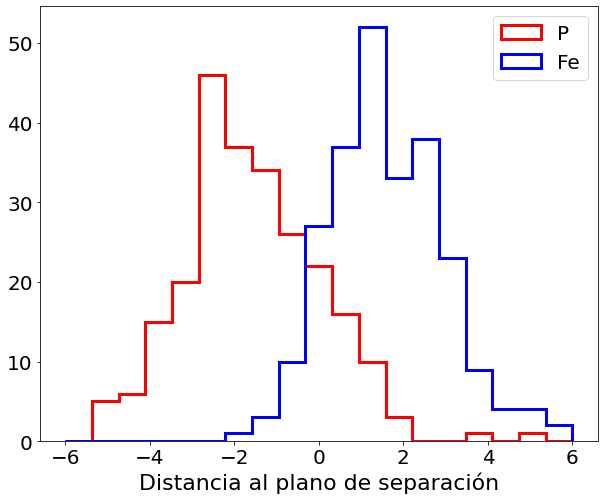

In [131]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [132]:
boostMF(c1_pred, c2_pred)

('1.51', '0.09')

In [133]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(1, 1000)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=10, cv=100, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=100, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,

In [134]:
model_svm_3p = rnd_search_cv.best_estimator_
model_svm_3p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=431.84146050738883, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [135]:
print(accuracy(X_train, y_train, model_svm_3p))
print(crossAccuracy(X_train, y_train, model_svm_3p))

0.8463114754098361
Accuracy:  0.834013605442177 0.06061774179705775
presicion:  0.7899090642003928 0.06097967833952182
recall:  0.9215 0.09774811734475732
F1_score:  0.8466229212144099 0.0589606845638312
None


In [136]:
mconfusion(X_train, y_train, model_svm_3p)

Matriz de confusión, 

[[182  62]
 [ 19 225]]
precisión:  0.7839721254355401
exhaustividad:  0.9221311475409836


In [137]:
print(classification_report(y_train, model_svm_3p.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      0.74      0.83       244
           1       0.78      0.95      0.86       244

    accuracy                           0.85       488
   macro avg       0.86      0.85      0.84       488
weighted avg       0.86      0.85      0.84       488



In [138]:
ypred = cross_val_predict(model_svm_3p, X_train, y_train, cv=5, method="decision_function")

In [139]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

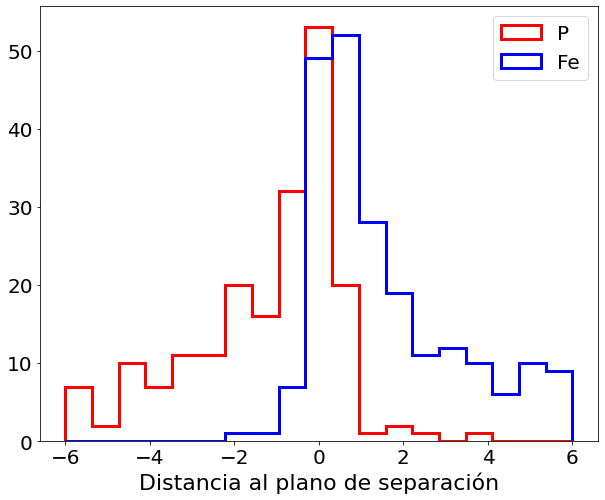

In [140]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [141]:
boostMF(c1_pred, c2_pred)

('0.50', '0.10')

In [142]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=100, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [143]:
model_svm_4 = rnd_search_cv.best_estimator_
model_svm_4

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=95.27238665859272, break_ties=False, cache_size=200,
                     class_weight=None, coef0=74.46617595858734,
                     decision_function_shape='ovr', degree=3,
                     gamma=2.932465325893527e-05, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [144]:
print(accuracy(X_train, y_train, model_svm_4))
print(crossAccuracy(X_train, y_train, model_svm_4))

0.8668032786885246
Accuracy:  0.8728316326530612 0.04807109371085327
presicion:  0.8515586893228718 0.04372190800047976
recall:  0.9051666666666668 0.07916736841794238
F1_score:  0.875802102037396 0.05104668701439263
None


In [145]:
mconfusion(X_train, y_train, model_svm_4)

Matriz de confusión, 

[[205  39]
 [ 23 221]]
precisión:  0.85
exhaustividad:  0.9057377049180327


In [146]:
print(classification_report(y_train, model_svm_4.predict(X_train)))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86       244
           1       0.84      0.91      0.87       244

    accuracy                           0.87       488
   macro avg       0.87      0.87      0.87       488
weighted avg       0.87      0.87      0.87       488



In [147]:
ypred = cross_val_predict(model_svm_4, X_train, y_train, cv=5, method="decision_function")

In [148]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

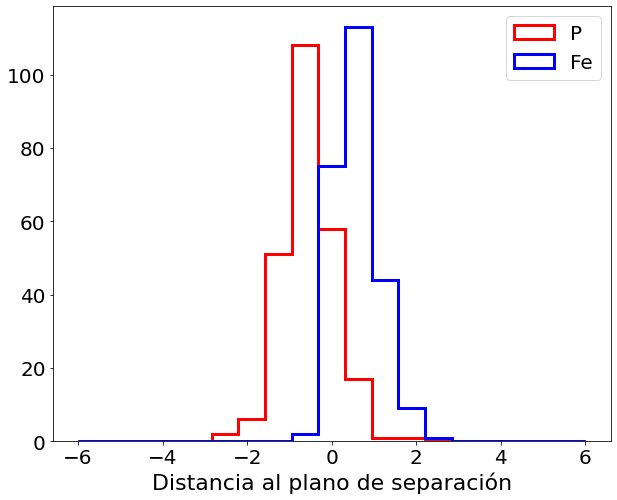

In [149]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [150]:
boostMF(c1_pred, c2_pred)

('1.49', '0.09')

In [151]:
svcP=model_svm_4.named_steps['svm_clf']

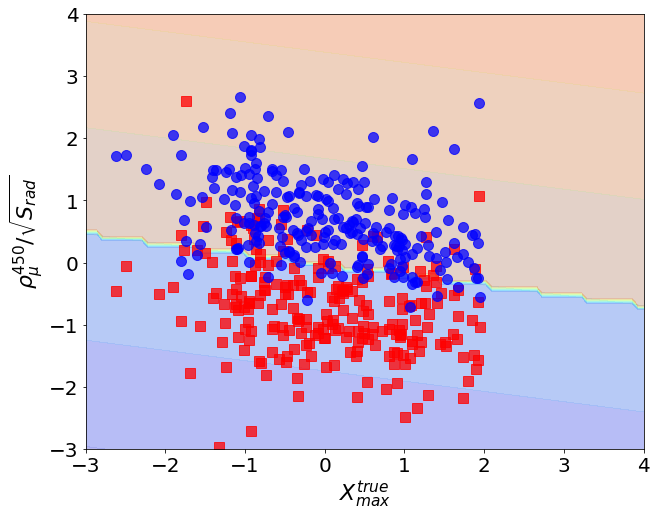

In [152]:
def plot_dataset(X, y, axes):
    plt.plot(XX[yy==0, 0], XX[yy==0, 1], "rs", markersize=10, alpha=0.75, label="P")
    plt.plot(XX[yy==1, 0], XX[yy==1, 1], "bo", markersize=10, alpha=0.75, label="Fe")

    #plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", markersize=10, alpha=0.75)
    #plt.plot(X[:, 0][y==1], X[:, 1][y==1], "ro", markersize=10, alpha=0.75)
    plt.axis(axes)
    #plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=22)
    plt.ylabel(r"$x_2$", fontsize=22, rotation=90)
    


#plot_dataset(X, y, [-6, 6, -1, 7])
#plot_dataset(XX, y, [-3, 4, -3, 7])
#plt.show()

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = model_svm_4.predict(X).reshape(x0.shape)
    y_decision = model_svm_4.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.jet, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.jet, alpha=0.1)

plt.figure(figsize=(10, 8))
plot_predictions(model_svm_4,[-3, 4, -3, 7])
plot_dataset(XX, y,[-3, 4, -3, 4])
plt.xlabel(r"$X^{true}_{max}$")
plt.ylabel(r"$\rho^{450}_{\mu} / \sqrt{S_{rad}}$")

plt.show()

## Variables base + Energía

In [153]:
#Features

df_train_2 = df_train[["GeoCeXmax", "Mu_rootSrad", "MC energy", "target"]]
df_test_2 = df_test[["GeoCeXmax", "Mu_rootSrad", "MC energy", "target"]]

In [154]:
print(df_train_2.shape, df_test_.shape)

(488, 4) (122, 64)


In [155]:
df_train_2.head()

,GeoCeXmax,Mu_rootSrad,MC energy,target
246,610.506,0.000717,3.824250e+17,1
76,670.556,0.000495,7.590210e+17,1
171,669.154,0.000614,6.116010e+17,1
191,571.015,0.000461,3.842740e+17,1
75,599.145,0.000438,9.452550e+17,1


In [156]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target         1.000000
Mu_rootSrad    0.652022
MC energy     -0.005095
GeoCeXmax     -0.461443
Name: target, dtype: float64

In [157]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 3) (488,) (488, 3) (122,)


In [158]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [159]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [160]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 3) (122, 3) (488,) (122,)


In [161]:
X_train.head()

,GeoCeXmax,Mu_rootSrad,MC energy
0,-0.751797,1.017026,-0.324464
1,0.260940,-0.177543,1.092195
2,0.238489,0.492047,0.651643
3,-1.481640,-0.380284,-0.314309
4,-0.956135,-0.522815,1.534527


In [162]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

In [163]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=100, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [164]:
model_Log_55 = rnd_search_cv.best_estimator_
model_Log_55

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=90.14585659413942, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [165]:
print(accuracy(X_train, y_train, model_Log_55))
print(crossAccuracy(X_train, y_train, model_Log_55))

0.860655737704918
Accuracy:  0.8584183673469388 0.06538142492806027
presicion:  0.8581601236927323 0.05169115853288566
recall:  0.8603333333333332 0.11231602240503753
F1_score:  0.855686934502671 0.07830374882473162
None


In [166]:
mconfusion(X_train, y_train, model_Log_55)

Matriz de confusión, 

[[209  35]
 [ 34 210]]
precisión:  0.8571428571428571
exhaustividad:  0.860655737704918


In [167]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_55.predict(X_train)))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       244
           1       0.85      0.87      0.86       244

    accuracy                           0.86       488
   macro avg       0.86      0.86      0.86       488
weighted avg       0.86      0.86      0.86       488



In [168]:
ypred = cross_val_predict(model_Log_55, X_train, y_train, cv=5, method="decision_function")

In [169]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

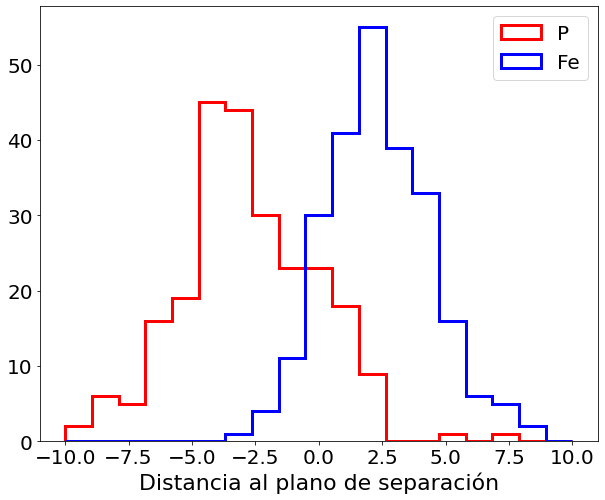

In [170]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [171]:
boostMF(c1_pred, c2_pred)

('1.52', '0.09')

In [172]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [173]:
model_svm_44 = rnd_search_cv.best_estimator_
model_svm_44

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=0.26970095355989376, break_ties=False, cache_size=200,
                     class_weight=None, coef0=86.68840809978838,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.02910164044318582, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [174]:
print(accuracy(X_train, y_train, model_svm_44))
print(crossAccuracy(X_train, y_train, model_svm_44))

0.8647540983606558
Accuracy:  0.8646258503401361 0.0456958737875413
presicion:  0.8241742618194232 0.03948423153371895
recall:  0.9296666666666666 0.08151278018405048
F1_score:  0.8717392698798907 0.048423466288401114
None


In [175]:
mconfusion(X_train, y_train, model_svm_44)

Matriz de confusión, 

[[195  49]
 [ 17 227]]
precisión:  0.822463768115942
exhaustividad:  0.930327868852459


In [176]:
print(classification_report(y_train, model_svm_44.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.80      0.86       244
           1       0.82      0.93      0.87       244

    accuracy                           0.86       488
   macro avg       0.87      0.86      0.86       488
weighted avg       0.87      0.86      0.86       488



In [421]:
ypred = cross_val_predict(model_svm_44, X_train, y_train, cv=5, method="decision_function")

In [422]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

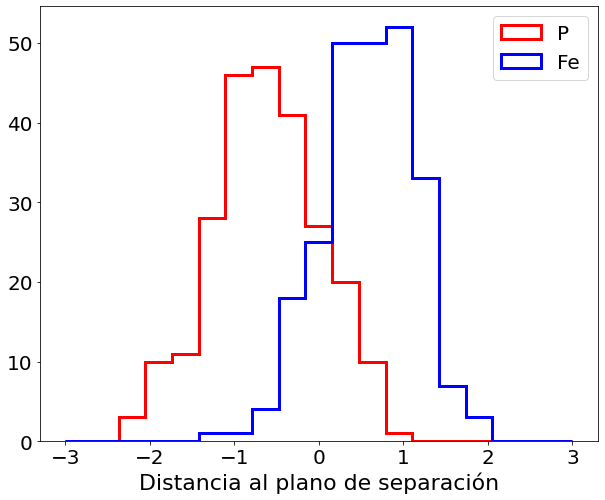

In [424]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-3, 3, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [180]:
boostMF(c1_pred, c2_pred)

('1.61', '0.09')

# Variables individuales

In [181]:
#Features

df_train_2 = df_train[["GeoCeXmax", "rootSrad", "N_mu_ref", "target"]]
df_test_2 = df_test[["GeoCeXmax", "rootSrad", "N_mu_ref", "target"]]

In [182]:
print(df_train_2.shape, df_test_.shape)

(488, 4) (122, 64)


In [183]:
df_train_2.head()

,GeoCeXmax,rootSrad,N_mu_ref,target
246,610.506,1186.642322,0.850606,1
76,670.556,2251.384019,1.114180,1
171,669.154,1867.359098,1.146870,1
191,571.015,1327.143549,0.612265,1
75,599.145,2809.946619,1.232080,1


In [184]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target       1.000000
N_mu_ref     0.384449
rootSrad    -0.057361
GeoCeXmax   -0.461443
Name: target, dtype: float64

In [185]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 3) (488,) (488, 3) (122,)


In [186]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [187]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [188]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 3) (122, 3) (488,) (122,)


In [189]:
X_train.head()

,GeoCeXmax,rootSrad,N_mu_ref
0,-0.751797,-0.190732,0.462230
1,0.260940,1.100626,1.066291
2,0.238489,0.722051,1.133262
3,-1.481640,0.033892,-0.224563
4,-0.956135,1.550809,1.301173


In [190]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

In [191]:
print(XX)

[[-0.75179729 -0.19073177  0.46222978]
 [ 0.26094042  1.10062603  1.06629128]
 [ 0.23848901  0.72205131  1.13326226]
 ...
 [-0.75318541  0.69673044 -0.4185472 ]
 [ 2.23809473  0.98599435  0.93574021]
 [ 1.55414211  1.10604562  0.96498853]]


In [192]:
def escala(method):
    
    Xss=XX
    y=yy

    plt.figure(figsize=(18, 22))

    plt.subplot(321)
    plt.plot(np.sqrt(dp["GeoCe Erad"]), dp['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="r", label="P")
    plt.plot(np.sqrt(df["GeoCe Erad"]), df['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
    plt.xlabel(r"$\sqrt{S_{rad}}$", fontsize=25)
    plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
    #plt.text(480, 0.0011, "(a)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()

    plt.subplot(322)
    plt.plot(Xss[y==0, 0], Xss[y==0, 1], 'o', alpha=0.4, markersize=12, color="r", label="P")
    plt.plot(Xss[y==1, 0], Xss[y==1, 1], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
    plt.xlabel(r"$\sqrt{S_{rad}}^*$", fontsize=25)
    #plt.text(-2.5, 2.5, "(b)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()

    plt.subplot(323)
    bins = np.linspace(0, 12E3, 25)
    plt.hist(np.sqrt(dp["GeoCe Erad"]), bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(np.sqrt(df["GeoCe Erad"]), bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\sqrt{S_{rad}}$", fontsize=25)
    #plt.text(500, 65, "(c)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()    
    
    
    plt.subplot(324)
    bins = np.linspace(-4, 4, 25)
    plt.hist(Xss[y==0, 1], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(Xss[y==1, 1], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\sqrt{S_{rad}}^*$", fontsize=25)
    #plt.text(-2.5, 45, "(d)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()
    
    plt.subplot(325)
    bins = np.linspace(0, 4, 20)
    plt.hist(dp['N_mu_ref'], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(df['N_mu_ref'], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\rho^{450}_{\mu}$", fontsize=25)
    plt.legend(fontsize=22)
    #plt.text(1.2E-4, 65, "(e)", c='k', fontsize=35)
    plt.grid()
    
    plt.subplot(326)
    bins = np.linspace(-4, 4, 18)
    plt.hist(Xss[y==0, 0], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(Xss[y==1, 0], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\rho^{450*}_{\mu}$", fontsize=25)
    #plt.text(-2.5, 47.5, "(f)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()
    

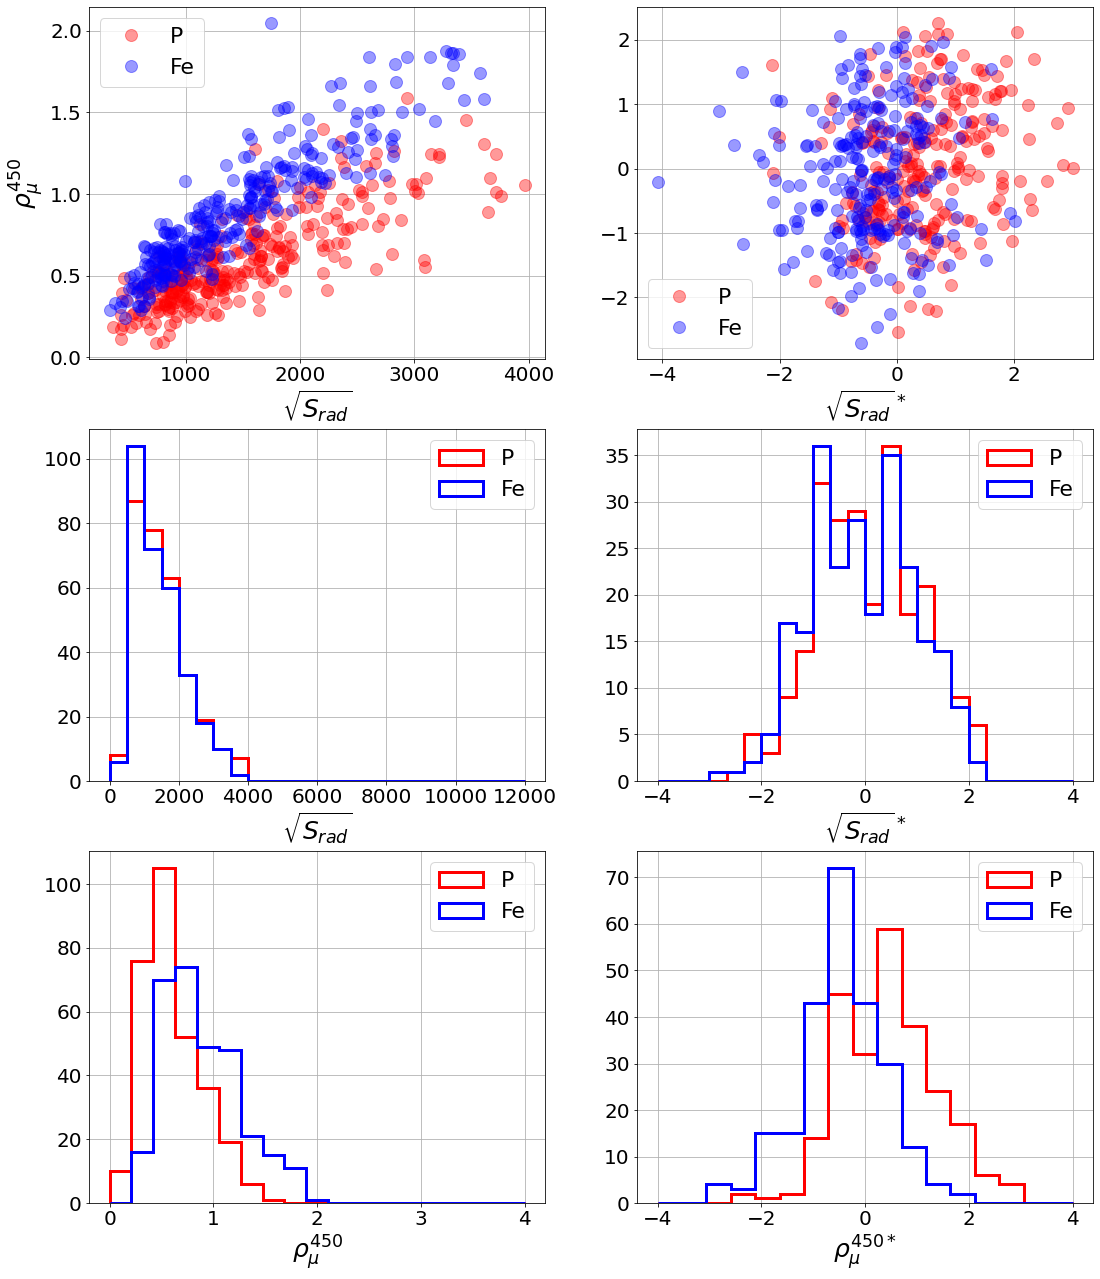

In [193]:
escala(PowerTransformer(method='box-cox'))

In [194]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=300, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [195]:
model_Log_5 = rnd_search_cv.best_estimator_
model_Log_5

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=1.4402903692310565, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [196]:
print(accuracy(X_train, y_train, model_Log_5))
print(crossAccuracy(X_train, y_train, model_Log_5))

0.889344262295082
Accuracy:  0.8768707482993197 0.057261174884074284
presicion:  0.8683266178266178 0.04770045969905779
recall:  0.8928333333333333 0.10893945821214437
F1_score:  0.8760504374331866 0.06772304837426342
None


In [197]:
mconfusion(X_train, y_train, model_Log_5)

Matriz de confusión, 

[[210  34]
 [ 26 218]]
precisión:  0.8650793650793651
exhaustividad:  0.8934426229508197


In [198]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_5.predict(X_train)))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       244
           1       0.87      0.91      0.89       244

    accuracy                           0.89       488
   macro avg       0.89      0.89      0.89       488
weighted avg       0.89      0.89      0.89       488



In [199]:
ypred = cross_val_predict(model_Log_5, X_train, y_train, cv=5, method="decision_function")

In [200]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

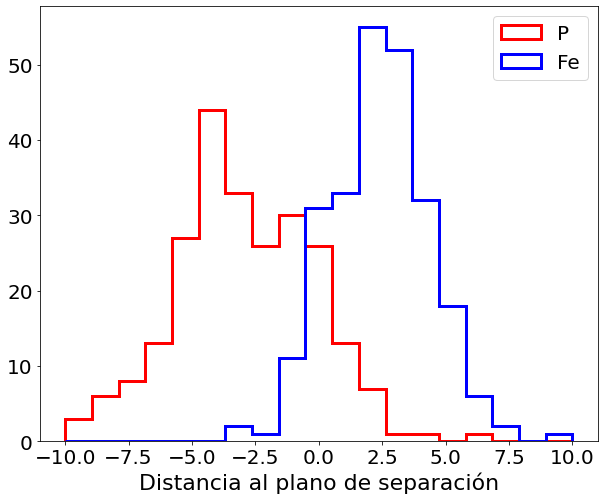

In [201]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [202]:
boostMF(c1_pred, c2_pred)

('1.57', '0.09')

In [203]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 19)

In [204]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 19)

In [205]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [206]:
model_Log_6 = rnd_search_cv.best_estimator_
model_Log_6

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=0.4188936066324199, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [207]:
print(accuracy(X_poly2, y_train, model_Log_6))
print(crossAccuracy(X_poly2, y_train, model_Log_6))

0.8954918032786885
Accuracy:  0.8749149659863946 0.060128368163946885
presicion:  0.8584974222155886 0.06490364109017502
recall:  0.9053333333333333 0.0835457293276496
F1_score:  0.8784190652127458 0.060550150812722935
None


In [208]:
mconfusion(X_poly2, y_train, model_Log_6)

Matriz de confusión, 

[[206  38]
 [ 23 221]]
precisión:  0.8532818532818532
exhaustividad:  0.9057377049180327


In [209]:
print(classification_report(y_train, model_Log_6.predict(X_poly2)))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       244
           1       0.88      0.92      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [210]:
ypred = cross_val_predict(model_Log_6, X_poly2, y_train, cv=5, method="decision_function")

In [211]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

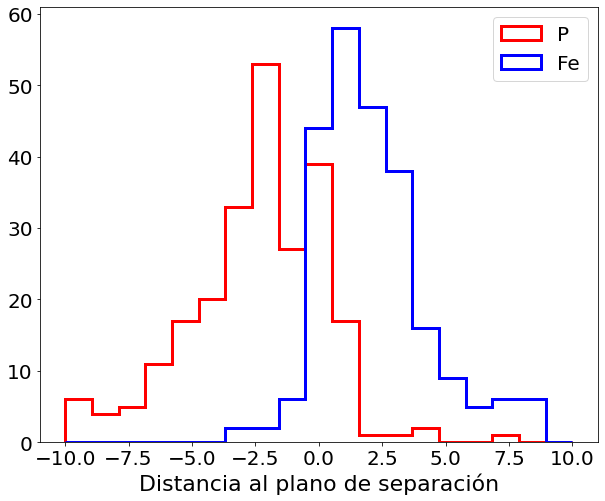

In [212]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [213]:
boostMF(c1_pred, c2_pred)

('1.13', '0.09')

## SVM

In [214]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [215]:
model_svm_5 = rnd_search_cv.best_estimator_
model_svm_5

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=0.0861650379798362, break_ties=False, cache_size=200,
                     class_weight=None, coef0=50.83281087975793,
                     decision_function_shape='ovr', degree=3,
                     gamma=1.5318628504839872e-05, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [216]:
print(accuracy(X_train, y_train, model_svm_5))
print(crossAccuracy(X_train, y_train, model_svm_5))

0.8770491803278688
Accuracy:  0.8687925170068027 0.06438826943673023
presicion:  0.8427176931542893 0.06369748409393629
recall:  0.9136666666666666 0.08377151464947179
F1_score:  0.8743558493342067 0.06103892144370114
None


In [217]:
mconfusion(X_train, y_train, model_svm_5)

Matriz de confusión, 

[[201  43]
 [ 21 223]]
precisión:  0.8383458646616542
exhaustividad:  0.9139344262295082


In [218]:
print(classification_report(y_train, model_svm_5.predict(X_train)))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87       244
           1       0.85      0.92      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.88       488
weighted avg       0.88      0.88      0.88       488



In [219]:
ypred = cross_val_predict(model_svm_5, X_train, y_train, cv=5, method="decision_function")

In [220]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

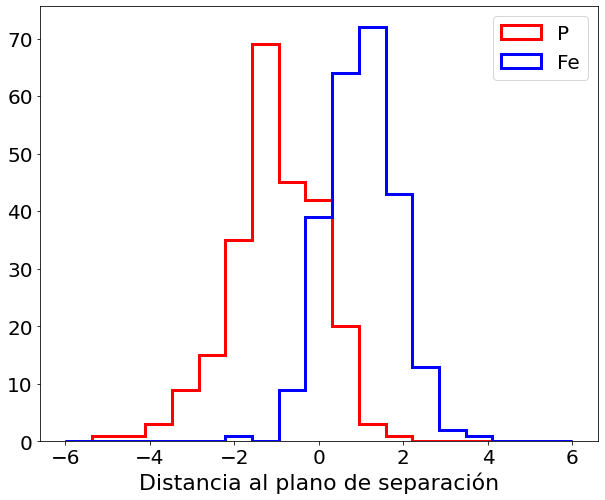

In [221]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [222]:
boostMF(c1_pred, c2_pred)

('1.55', '0.08')

In [223]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,

In [224]:
model_svm_5p = rnd_search_cv.best_estimator_
model_svm_5p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=2.228049994698733, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [225]:
print(accuracy(X_train, y_train, model_svm_5p))
print(crossAccuracy(X_train, y_train, model_svm_5p))

0.8790983606557377
Accuracy:  0.8749574829931973 0.05778699413630353
presicion:  0.8533171617030313 0.06308442126211702
recall:  0.9138333333333334 0.08176541648724925
F1_score:  0.8796818959733581 0.05556824336621926
None


In [226]:
mconfusion(X_train, y_train, model_svm_5p)

Matriz de confusión, 

[[204  40]
 [ 21 223]]
precisión:  0.8479087452471483
exhaustividad:  0.9139344262295082


In [227]:
print(classification_report(y_train, model_svm_5p.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       244
           1       0.84      0.93      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.88       488
weighted avg       0.88      0.88      0.88       488



In [228]:
ypred = cross_val_predict(model_svm_5p, X_train, y_train, cv=5, method="decision_function")

In [229]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

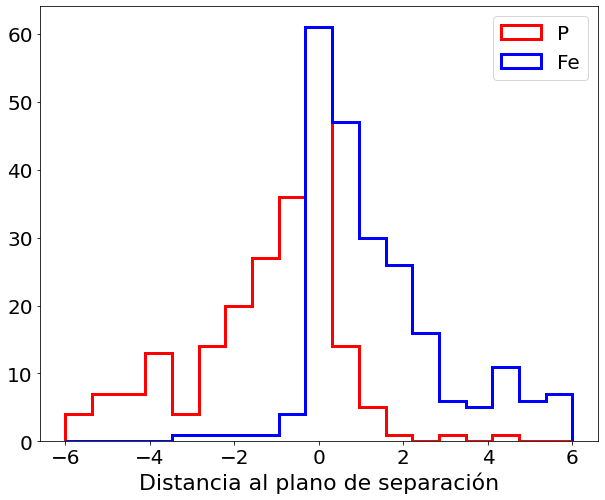

In [230]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [231]:
boostMF(c1_pred, c2_pred)

('0.83', '0.07')

In [232]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [233]:
model_svm_6 = rnd_search_cv.best_estimator_
model_svm_6

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=69.55902039497852, break_ties=False, cache_size=200,
                     class_weight=None, coef0=70.07121564043976,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.0026613207514432015, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [234]:
print(accuracy(X_train, y_train, model_svm_6))
print(crossAccuracy(X_train, y_train, model_svm_6))

0.8852459016393442
Accuracy:  0.881079931972789 0.05042095762538246
presicion:  0.8638698019732501 0.047060067532229674
recall:  0.9094999999999999 0.0887163081588348
F1_score:  0.883102606986704 0.0539176847961442
None


In [235]:
mconfusion(X_train, y_train, model_svm_6)

Matriz de confusión, 

[[208  36]
 [ 22 222]]
precisión:  0.8604651162790697
exhaustividad:  0.9098360655737705


In [236]:
print(classification_report(y_train, model_svm_6.predict(X_train)))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       244
           1       0.86      0.91      0.89       244

    accuracy                           0.89       488
   macro avg       0.89      0.89      0.89       488
weighted avg       0.89      0.89      0.89       488



In [237]:
ypred = cross_val_predict(model_svm_6, X_train, y_train, cv=5, method="decision_function")

In [238]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

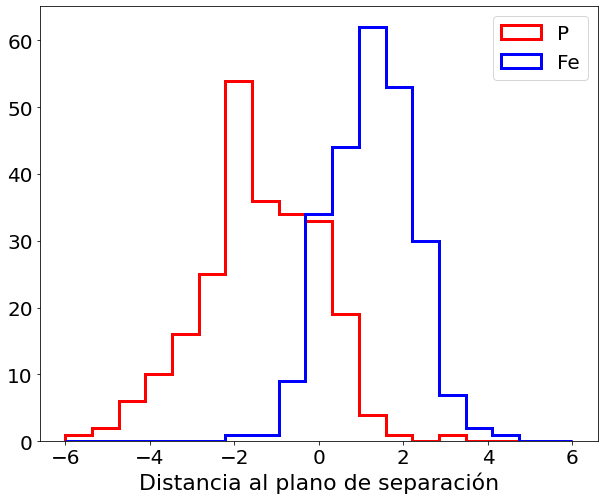

In [239]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [240]:
boostMF(c1_pred, c2_pred)

('1.58', '0.09')

## Incluyendo la Energía

In [47]:
#Features

df_train_2 = df_train[["GeoCeXmax", "rootSrad", "N_mu_ref", "MC energy", "target"]]
df_test_2 = df_test[["GeoCeXmax", "rootSrad", "N_mu_ref", "MC energy", "target"]]

In [48]:
print(df_train_2.shape, df_test_.shape)

(488, 5) (122, 64)


In [49]:
df_train_2.head()

,GeoCeXmax,rootSrad,N_mu_ref,MC energy,target
246,610.506,1186.642322,0.850606,3.824250e+17,1
76,670.556,2251.384019,1.114180,7.590210e+17,1
171,669.154,1867.359098,1.146870,6.116010e+17,1
191,571.015,1327.143549,0.612265,3.842740e+17,1
75,599.145,2809.946619,1.232080,9.452550e+17,1


In [50]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target       1.000000
N_mu_ref     0.384449
MC energy   -0.005095
rootSrad    -0.057361
GeoCeXmax   -0.461443
Name: target, dtype: float64

In [51]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 4) (488,) (488, 4) (122,)


In [52]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [53]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [54]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 4) (122, 4) (488,) (122,)


In [55]:
X_train.head()

,GeoCeXmax,rootSrad,N_mu_ref,MC energy
0,-0.751797,-0.190732,0.462230,-0.324464
1,0.260940,1.100626,1.066291,1.092195
2,0.238489,0.722051,1.133262,0.651643
3,-1.481640,0.033892,-0.224563,-0.314309
4,-0.956135,1.550809,1.301173,1.534527


In [56]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

In [463]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=100, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [464]:
model_Log_7 = rnd_search_cv.best_estimator_
model_Log_7

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=202.4825547891842, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [465]:
print(accuracy(X_train, y_train, model_Log_7))
print(crossAccuracy(X_train, y_train, model_Log_7))

0.9016393442622951
Accuracy:  0.8995748299319729 0.048172275306400676
presicion:  0.8905860443903922 0.0495580546000501
recall:  0.9136666666666666 0.06511442919114695
F1_score:  0.9007710711542074 0.047312861038369944
None


In [466]:
print(crossAccuracy(X_test, y_test, model_Log_7))

Accuracy:  0.8294871794871795 0.11439030271125311
presicion:  0.8195238095238097 0.12295400389914081
recall:  0.869047619047619 0.09945999321050202
F1_score:  0.8397024544083367 0.09866601427802614
None


In [457]:
mconfusion(X_train, y_train, model_Log_7)

Matriz de confusión, 

[[216  28]
 [ 21 223]]
precisión:  0.8884462151394422
exhaustividad:  0.9139344262295082


In [458]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_7.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       244
           1       0.89      0.92      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [459]:
ypred = cross_val_predict(model_Log_7, X_train, y_train, cv=5, method="decision_function")

In [460]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

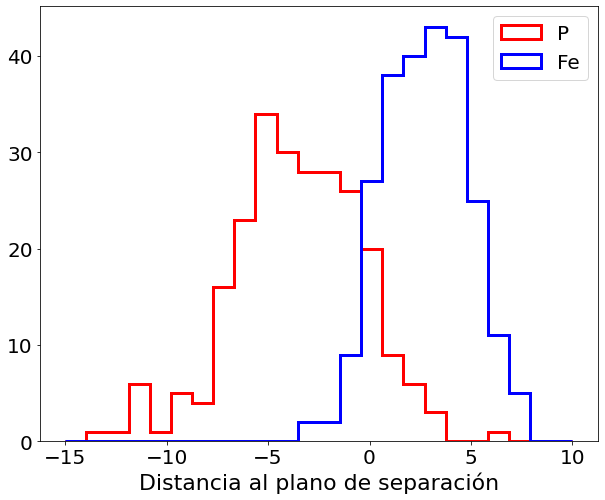

In [461]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-15, 10, 25)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [462]:
boostMF(c1_pred, c2_pred)

('1.64', '0.09')

In [474]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 34)

In [475]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 34)

In [480]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [481]:
model_Log_8 = rnd_search_cv.best_estimator_
model_Log_8

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=1.1064373384093598, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [482]:
print(accuracy(X_poly2, y_train, model_Log_8))
print(crossAccuracy(X_poly2, y_train, model_Log_8))

0.9118852459016393
Accuracy:  0.8913265306122449 0.04619319682308598
presicion:  0.8709449917898194 0.044775647092599465
recall:  0.9215 0.07061417075283906
F1_score:  0.8939414975061876 0.046604481359792053
None


In [483]:
print(crossAccuracy(X_poly2_test, y_test, model_Log_8))

Accuracy:  0.8358974358974359 0.11796265246562505
presicion:  0.8099206349206349 0.12047360245667466
recall:  0.8666666666666668 0.19436506316151
F1_score:  0.8310464535464535 0.14830017872753584
None


In [470]:
mconfusion(X_poly2, y_train, model_Log_8)

Matriz de confusión, 

[[216  28]
 [ 26 218]]
precisión:  0.8861788617886179
exhaustividad:  0.8934426229508197


In [484]:
print(classification_report(y_train, model_Log_8.predict(X_poly2)))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       244
           1       0.89      0.94      0.91       244

    accuracy                           0.91       488
   macro avg       0.91      0.91      0.91       488
weighted avg       0.91      0.91      0.91       488



In [485]:
ypred = cross_val_predict(model_Log_8, X_poly2, y_train, cv=5, method="decision_function")

In [486]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

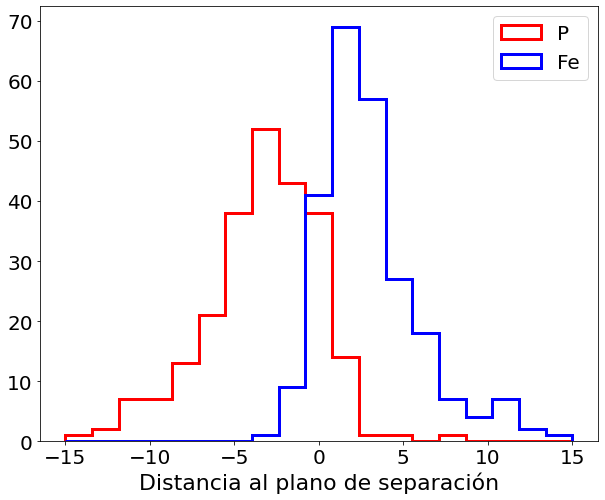

In [487]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-15, 15, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [488]:
boostMF(c1_pred, c2_pred)

('1.23', '0.09')

## SVM

In [88]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 10), "svm_clf__C": uniform(0.1, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [89]:
model_svm_7 = rnd_search_cv.best_estimator_
model_svm_7

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=39.99754910802768, break_ties=False, cache_size=200,
                     class_weight=None, coef0=14.660319032532398,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.0014135801262410315, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [90]:
print(accuracy(X_train, y_train, model_svm_7))
print(crossAccuracy(X_train, y_train, model_svm_7))

0.8995901639344263
Accuracy:  0.8996173469387754 0.044380281416586266
presicion:  0.8807971810797899 0.04542858061203079
recall:  0.9259999999999999 0.051640853766933184
F1_score:  0.9022371937936156 0.042730423698643834
None


In [91]:
auc_cv(X_train, y_train, model_svm_7)

0.9583472222222221 0.034225020741455905


In [92]:
print(crossAccuracy(X_test, y_test, model_svm_7))

Accuracy:  0.8615384615384617 0.1016465366303323
presicion:  0.8428571428571429 0.10605265453009567
recall:  0.9023809523809524 0.10934250003052413
F1_score:  0.8684731934731934 0.0938652013146717
None


In [93]:
auc_cv(X_test, y_test, model_svm_7)

0.9059523809523811 0.0983622822729734


In [94]:
mconfusion(X_train, y_train, model_svm_7)

Matriz de confusión, 

[[213  31]
 [ 18 226]]
precisión:  0.8793774319066148
exhaustividad:  0.9262295081967213


In [95]:
#print(classification_report(y_train, model_svm_7.predict(X_train)))

In [96]:
ypred = cross_val_predict(model_svm_7, X_train, y_train, cv=5, method="decision_function")

In [97]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

Saving figure obs_4_hist_best


/home/csarmiento/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later


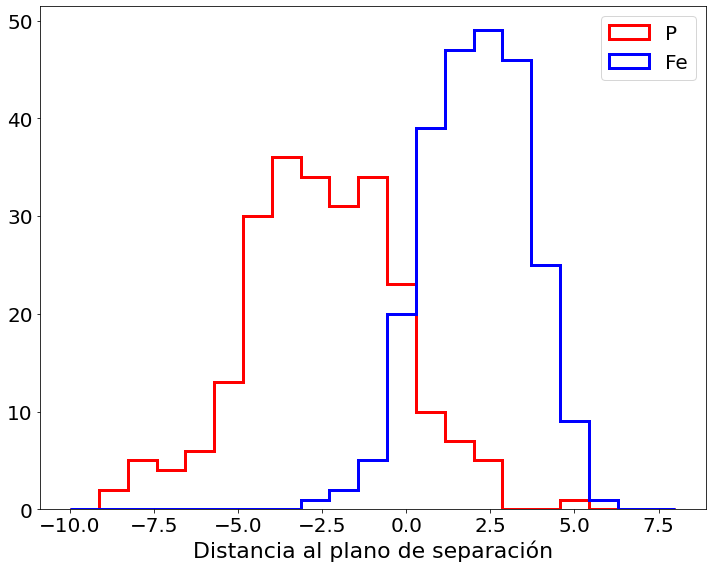

In [100]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 8, 22)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)
#save_fig("obs_4_hist_best")
plt.show()

In [99]:
boostMF(c1_pred, c2_pred)

('1.66', '0.09')

In [280]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,

In [281]:
model_svm_7p = rnd_search_cv.best_estimator_
model_svm_7p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=37.75497315340501, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [282]:
print(accuracy(X_train, y_train, model_svm_7p))
print(crossAccuracy(X_train, y_train, model_svm_7p))

0.8975409836065574
Accuracy:  0.8954931972789115 0.03829590613223513
presicion:  0.8667415181298239 0.0569527901939007
recall:  0.9421666666666667 0.042694326971572646
F1_score:  0.9010433172939406 0.032835126735262656
None


In [283]:
mconfusion(X_train, y_train, model_svm_7p)

Matriz de confusión, 

[[207  37]
 [ 14 230]]
precisión:  0.8614232209737828
exhaustividad:  0.9426229508196722


In [284]:
print(classification_report(y_train, model_svm_7p.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89       244
           1       0.86      0.95      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [285]:
ypred = cross_val_predict(model_svm_7p, X_train, y_train, cv=5, method="decision_function")

In [286]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

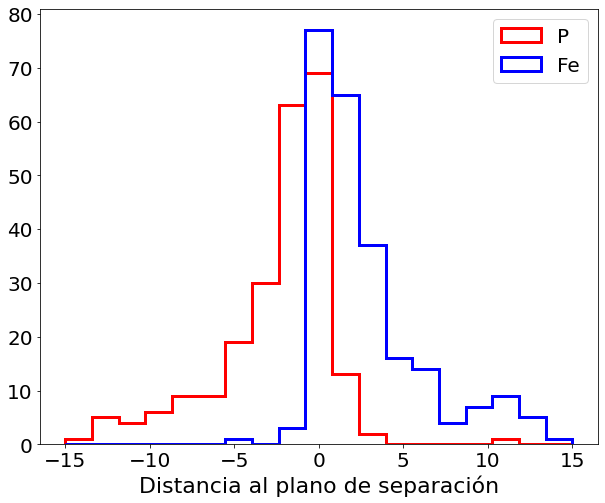

In [287]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-15, 15, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [288]:
boostMF(c1_pred, c2_pred)

('0.83', '0.06')

In [289]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.1, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [290]:
model_svm_8 = rnd_search_cv.best_estimator_
model_svm_8

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=86.19782419685852, break_ties=False, cache_size=200,
                     class_weight=None, coef0=70.36977710417062,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.011920703438451634, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [498]:
print(accuracy(X_train, y_train, model_svm_8))
print(crossAccuracy(X_train, y_train, model_svm_8))

0.8975409836065574
Accuracy:  0.8954931972789115 0.045273246023426576
presicion:  0.8773779264214048 0.048433816607571574
recall:  0.922 0.050386285612037104
F1_score:  0.8984581811849589 0.04291064476695247
None


In [499]:
print(crossAccuracy(X_test, y_test, model_svm_8))

Accuracy:  0.8455128205128204 0.11078621961362688
presicion:  0.8264285714285714 0.10946401059029617
recall:  0.8857142857142858 0.12945025922922082
F1_score:  0.8513902763902765 0.1072104543569664
None


In [500]:
mconfusion(X_train, y_train, model_svm_8)

Matriz de confusión, 

[[212  32]
 [ 19 225]]
precisión:  0.8754863813229572
exhaustividad:  0.9221311475409836


In [501]:
print(classification_report(y_train, model_svm_8.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       244
           1       0.88      0.93      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [502]:
ypred = cross_val_predict(model_svm_8, X_train, y_train, cv=5, method="decision_function")

In [503]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

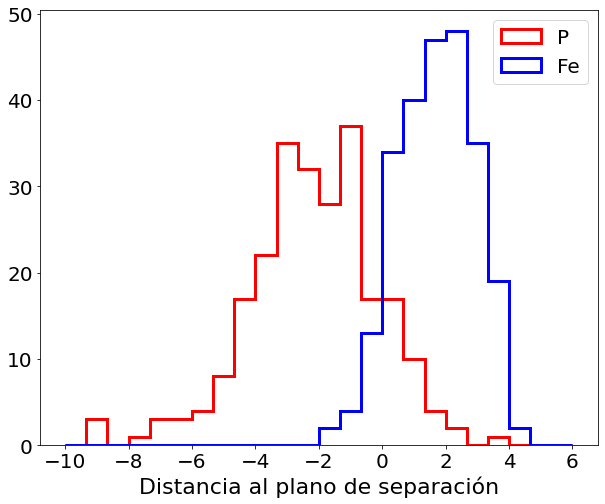

In [504]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 6, 25)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [297]:
boostMF(c1_pred, c2_pred)

('1.66', '0.09')

## Sumando el ángulo cenital 

In [298]:
#Features

df_train_2 = df_train[["GeoCeXmax", "MC zenith", "rootSrad", "N_mu_ref", "MC energy", "target"]]
df_test_2 = df_test[["GeoCeXmax", "MC zenith", "rootSrad", "N_mu_ref", "MC energy", "target"]]

In [299]:
print(df_train_2.shape, df_test_.shape)

(488, 6) (122, 64)


In [300]:
df_train_2.head()

,GeoCeXmax,MC zenith,rootSrad,N_mu_ref,MC energy,target
246,610.506,50.0277,1186.642322,0.850606,3.824250e+17,1
76,670.556,50.6696,2251.384019,1.114180,7.590210e+17,1
171,669.154,40.6307,1867.359098,1.146870,6.116010e+17,1
191,571.015,53.6568,1327.143549,0.612265,3.842740e+17,1
75,599.145,49.0955,2809.946619,1.232080,9.452550e+17,1


In [301]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target       1.000000
N_mu_ref     0.384449
MC zenith    0.016190
MC energy   -0.005095
rootSrad    -0.057361
GeoCeXmax   -0.461443
Name: target, dtype: float64

In [302]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 5) (488,) (488, 5) (122,)


In [303]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [304]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [305]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 5) (122, 5) (488,) (122,)


In [306]:
X_train.head()

,GeoCeXmax,MC zenith,rootSrad,N_mu_ref,MC energy
0,-0.751797,0.607596,-0.190732,0.462230,-0.324464
1,0.260940,0.757615,1.100626,1.066291,1.092195
2,0.238489,-1.051059,0.722051,1.133262,0.651643
3,-1.481640,1.527753,0.033892,-0.224563,-0.314309
4,-0.956135,0.398978,1.550809,1.301173,1.534527


In [307]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

In [308]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=300, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [309]:
model_Log_9 = rnd_search_cv.best_estimator_
model_Log_9

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=0.7523100678954452, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [310]:
print(accuracy(X_train, y_train, model_Log_9))
print(crossAccuracy(X_train, y_train, model_Log_9))

0.8975409836065574
Accuracy:  0.8934098639455783 0.04841716440087553
presicion:  0.8793466131292218 0.04687854438883702
recall:  0.9136666666666666 0.06511442919114695
F1_score:  0.8951749870299175 0.047737099948115196
None


In [311]:
mconfusion(X_train, y_train, model_Log_9)

Matriz de confusión, 

[[213  31]
 [ 21 223]]
precisión:  0.8779527559055118
exhaustividad:  0.9139344262295082


In [312]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_9.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       244
           1       0.88      0.92      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [313]:
ypred = cross_val_predict(model_Log_9, X_train, y_train, cv=5, method="decision_function")

In [314]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

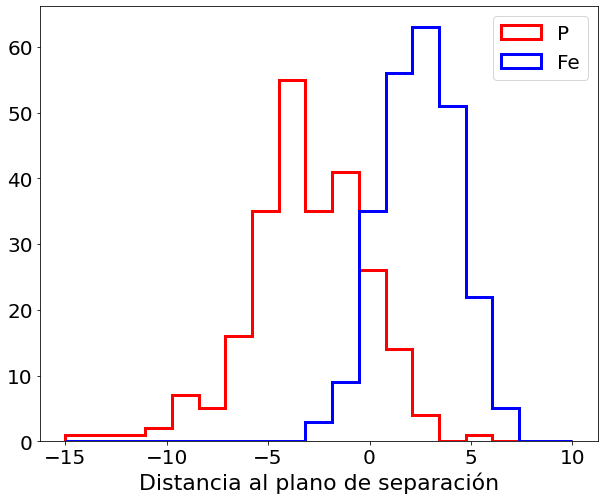

In [315]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-15, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [316]:
boostMF(c1_pred, c2_pred)

('1.66', '0.09')

In [317]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 55)

In [318]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 55)

In [319]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=300, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [320]:
model_Log_10 = rnd_search_cv.best_estimator_
model_Log_10

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=0.7480779829962535, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [321]:
print(accuracy(X_poly2, y_train, model_Log_10))
print(crossAccuracy(X_poly2, y_train, model_Log_10))

0.9221311475409836
Accuracy:  0.8913265306122449 0.04042300928061012
presicion:  0.885982747829955 0.05003518545933948
recall:  0.9049999999999999 0.0873975590810941
F1_score:  0.8913680617685473 0.04598915783226384
None


In [322]:
mconfusion(X_poly2, y_train, model_Log_10)

Matriz de confusión, 

[[214  30]
 [ 23 221]]
precisión:  0.8804780876494024
exhaustividad:  0.9057377049180327


In [323]:
print(classification_report(y_train, model_Log_10.predict(X_poly2)))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       244
           1       0.92      0.92      0.92       244

    accuracy                           0.92       488
   macro avg       0.92      0.92      0.92       488
weighted avg       0.92      0.92      0.92       488



In [324]:
ypred = cross_val_predict(model_Log_10, X_poly2, y_train, cv=5, method="decision_function")

In [325]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

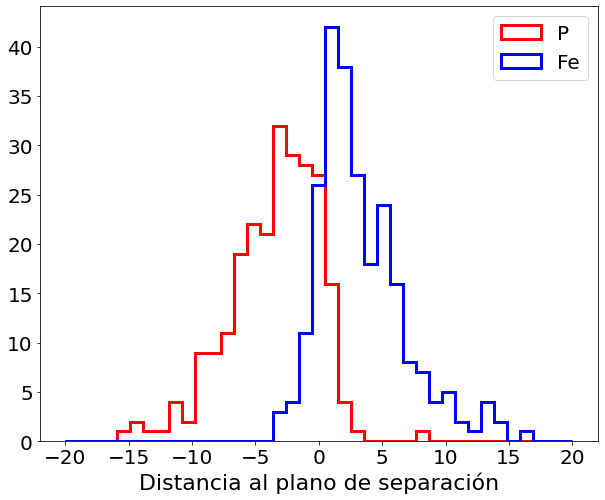

In [326]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-20, 20, 40)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [327]:
boostMF(c1_pred, c2_pred)

('1.21', '0.09')

## SVM

In [328]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [329]:
model_svm_9 = rnd_search_cv.best_estimator_
model_svm_9

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=2.077878945181056, break_ties=False, cache_size=200,
                     class_weight=None, coef0=21.88253259857229,
                     decision_function_shape='ovr', degree=3,
                     gamma=1.597142951886549e-05, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [330]:
print(accuracy(X_train, y_train, model_svm_9))
print(crossAccuracy(X_train, y_train, model_svm_9))

0.9016393442622951
Accuracy:  0.8975340136054422 0.04598642286055565
presicion:  0.8840753473579561 0.049460194400780956
recall:  0.9176666666666666 0.06159996392495337
F1_score:  0.899373291896131 0.045316651239886985
None


In [331]:
mconfusion(X_train, y_train, model_svm_9)

Matriz de confusión, 

[[214  30]
 [ 20 224]]
precisión:  0.8818897637795275
exhaustividad:  0.9180327868852459


In [332]:
print(classification_report(y_train, model_svm_9.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       244
           1       0.89      0.92      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [333]:
ypred = cross_val_predict(model_svm_9, X_train, y_train, cv=5, method="decision_function")

In [334]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

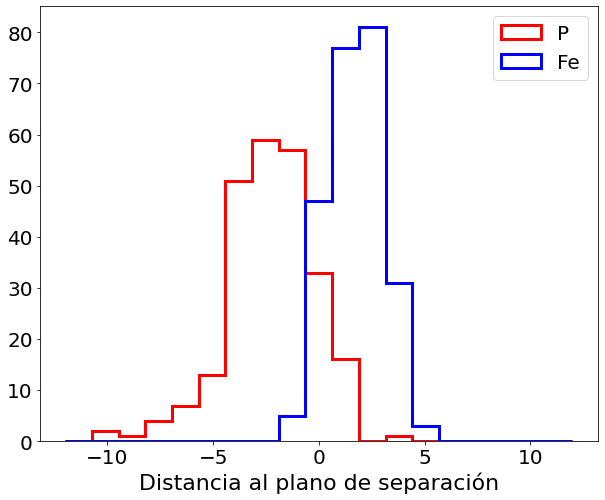

In [335]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-12, 12, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [336]:
boostMF(c1_pred, c2_pred)

('1.66', '0.09')

In [337]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(0.1, 1000)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=10, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,


In [338]:
model_svm_9p = rnd_search_cv.best_estimator_
model_svm_9p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=20.43637530422583, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [339]:
print(accuracy(X_train, y_train, model_svm_9p))
print(crossAccuracy(X_train, y_train, model_svm_9p))

0.8995901639344263
Accuracy:  0.8645833333333334 0.038894696323844895
presicion:  0.8704849958845902 0.05063277672218563
recall:  0.8639999999999999 0.09015480513477299
F1_score:  0.8628041947566671 0.04753060231669641
None


In [340]:
mconfusion(X_train, y_train, model_svm_9p)

Matriz de confusión, 

[[211  33]
 [ 33 211]]
precisión:  0.8647540983606558
exhaustividad:  0.8647540983606558


In [341]:
print(classification_report(y_train, model_svm_9p.predict(X_train)))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       244
           1       0.89      0.91      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [342]:
ypred = cross_val_predict(model_svm_9p, X_train, y_train, cv=5, method="decision_function")

In [343]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

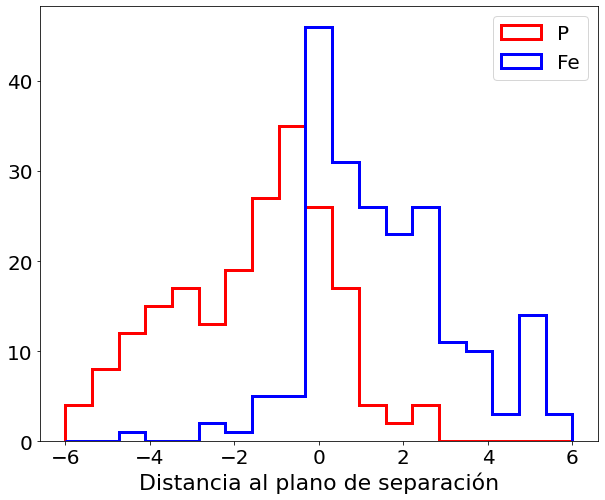

In [344]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [345]:
boostMF(c1_pred, c2_pred)

('0.94', '0.07')

In [346]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=500, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [347]:
model_svm_10 = rnd_search_cv.best_estimator_
model_svm_10

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=59.1256931286002, break_ties=False, cache_size=200,
                     class_weight=None, coef0=15.831101501862065,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.015490598267335344, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [348]:
print(accuracy(X_train, y_train, model_svm_10))
print(crossAccuracy(X_train, y_train, model_svm_10))

0.9077868852459017
Accuracy:  0.9036989795918368 0.05440623781897346
presicion:  0.8953823326432022 0.05842628121750408
recall:  0.9175000000000001 0.07390778789215052
F1_score:  0.9045805607097688 0.05470587327641323
None


In [349]:
mconfusion(X_train, y_train, model_svm_10)

Matriz de confusión, 

[[217  27]
 [ 20 224]]
precisión:  0.8924302788844621
exhaustividad:  0.9180327868852459


In [350]:
print(classification_report(y_train, model_svm_10.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91       244
           1       0.89      0.93      0.91       244

    accuracy                           0.91       488
   macro avg       0.91      0.91      0.91       488
weighted avg       0.91      0.91      0.91       488



In [351]:
ypred = cross_val_predict(model_svm_10, X_train, y_train, cv=5, method="decision_function")

In [352]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

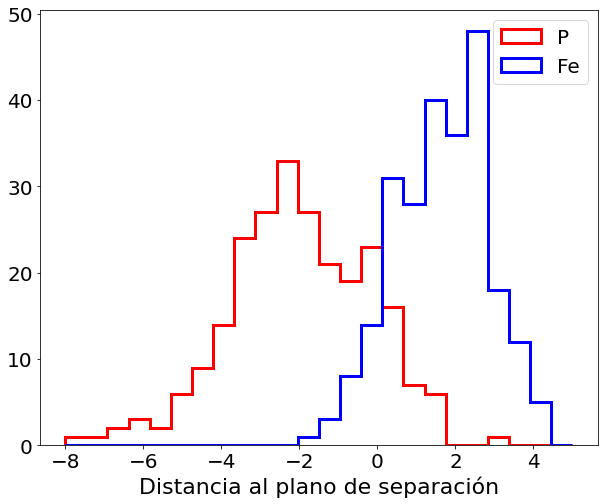

In [353]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-8, 5, 25)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [354]:
boostMF(c1_pred, c2_pred)

('1.68', '0.09')

In [355]:
"Stations with Pulse"

'Stations with Pulse'

## Sumando estaciones de Radio

In [356]:
#Features

df_train_2 = df_train[["GeoCeXmax", "MC zenith", "Stations with Pulse", "rootSrad", "N_mu_ref", "MC energy", "target"]]
df_test_2 = df_test[["GeoCeXmax", "MC zenith", "Stations with Pulse", "rootSrad", "N_mu_ref", "MC energy", "target"]]

In [357]:
print(df_train_2.shape, df_test_.shape)

(488, 7) (122, 64)


In [358]:
df_train_2.head()

,GeoCeXmax,MC zenith,Stations with Pulse,rootSrad,N_mu_ref,MC energy,target
246,610.506,50.0277,5,1186.642322,0.850606,3.824250e+17,1
76,670.556,50.6696,6,2251.384019,1.114180,7.590210e+17,1
171,669.154,40.6307,7,1867.359098,1.146870,6.116010e+17,1
191,571.015,53.6568,31,1327.143549,0.612265,3.842740e+17,1
75,599.145,49.0955,9,2809.946619,1.232080,9.452550e+17,1


In [359]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target                 1.000000
N_mu_ref               0.384449
Stations with Pulse    0.031046
MC zenith              0.016190
MC energy             -0.005095
rootSrad              -0.057361
GeoCeXmax             -0.461443
Name: target, dtype: float64

In [360]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 6) (488,) (488, 6) (122,)


In [361]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [362]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [363]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 6) (122, 6) (488,) (122,)


In [364]:
X_train.head()

,GeoCeXmax,MC zenith,Stations with Pulse,rootSrad,N_mu_ref,MC energy
0,-0.751797,0.607596,-1.310774,-0.190732,0.462230,-0.324464
1,0.260940,0.757615,-0.712103,1.100626,1.066291,1.092195
2,0.238489,-1.051059,-0.284582,0.722051,1.133262,0.651643
3,-1.481640,1.527753,1.699532,0.033892,-0.224563,-0.314309
4,-0.956135,0.398978,0.285287,1.550809,1.301173,1.534527


In [365]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

In [366]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 1000)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=300, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [367]:
model_Log_10 = rnd_search_cv.best_estimator_
model_Log_10

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=384.5252387260863, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [368]:
print(accuracy(X_train, y_train, model_Log_10))
print(crossAccuracy(X_train, y_train, model_Log_10))

0.9016393442622951
Accuracy:  0.8954506802721088 0.054047277224787416
presicion:  0.8866807934416631 0.05548861433444028
recall:  0.9095000000000001 0.07357177145859378
F1_score:  0.8964647193890963 0.0542785611673059
None


In [369]:
mconfusion(X_train, y_train, model_Log_10)

Matriz de confusión, 

[[215  29]
 [ 22 222]]
precisión:  0.8844621513944223
exhaustividad:  0.9098360655737705


In [370]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_10.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       244
           1       0.89      0.92      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [371]:
ypred = cross_val_predict(model_Log_10, X_train, y_train, cv=5, method="decision_function")

In [372]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

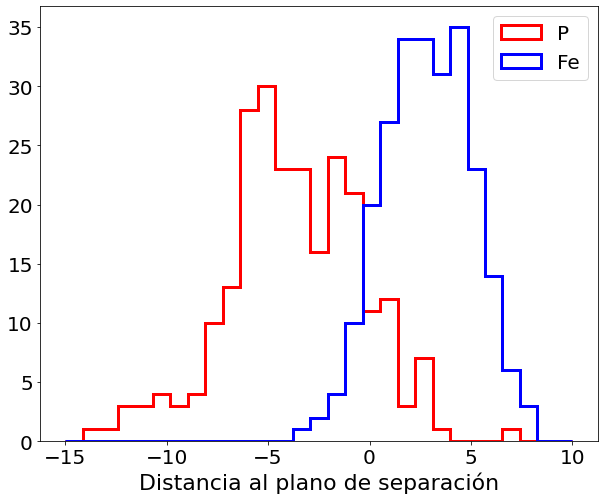

In [373]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-15, 10, 30)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [374]:
boostMF(c1_pred, c2_pred)

('1.63', '0.09')

In [375]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 83)

In [376]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 83)

In [377]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [378]:
model_Log_11 = rnd_search_cv.best_estimator_
model_Log_11

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=0.4049909484391544, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [379]:
print(accuracy(X_poly2, y_train, model_Log_11))
print(crossAccuracy(X_poly2, y_train, model_Log_11))

0.9323770491803278
Accuracy:  0.8892006802721089 0.054808429237647116
presicion:  0.8920436918154311 0.05984351166645185
recall:  0.8925000000000001 0.10070653184156207
F1_score:  0.8875549290045092 0.0613530923703699
None


In [380]:
mconfusion(X_poly2, y_train, model_Log_11)

Matriz de confusión, 

[[216  28]
 [ 26 218]]
precisión:  0.8861788617886179
exhaustividad:  0.8934426229508197


In [381]:
print(classification_report(y_train, model_Log_11.predict(X_poly2)))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       244
           1       0.92      0.95      0.93       244

    accuracy                           0.93       488
   macro avg       0.93      0.93      0.93       488
weighted avg       0.93      0.93      0.93       488



In [382]:
ypred = cross_val_predict(model_Log_11, X_poly2, y_train, cv=5, method="decision_function")

In [383]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

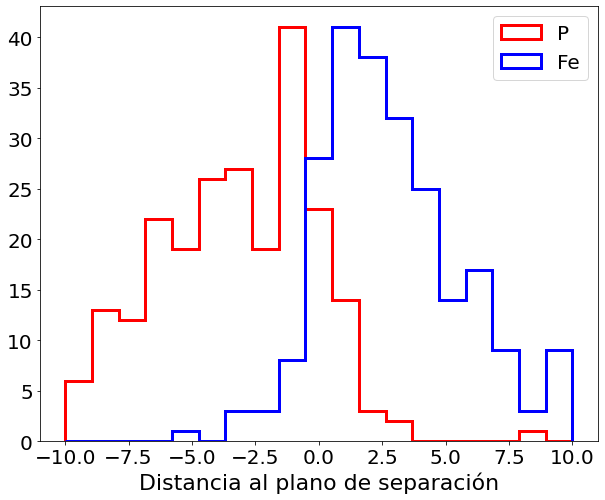

In [384]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [385]:
boostMF(c1_pred, c2_pred)

('1.16', '0.10')

## SVM

In [386]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [387]:
model_svm_10 = rnd_search_cv.best_estimator_
model_svm_10

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=6.638124574141402, break_ties=False, cache_size=200,
                     class_weight=None, coef0=41.513030416006465,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.12282522093270826, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [388]:
print(accuracy(X_train, y_train, model_svm_10))
print(crossAccuracy(X_train, y_train, model_svm_10))

0.8975409836065574
Accuracy:  0.8975340136054424 0.0450716370008585
presicion:  0.8772128427128427 0.04359612070463327
recall:  0.9258333333333333 0.06102936451687281
F1_score:  0.8999687674022091 0.04472306158505926
None


In [389]:
mconfusion(X_train, y_train, model_svm_10)

Matriz de confusión, 

[[212  32]
 [ 18 226]]
precisión:  0.875968992248062
exhaustividad:  0.9262295081967213


In [390]:
print(classification_report(y_train, model_svm_10.predict(X_train)))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       244
           1       0.87      0.93      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [391]:
ypred = cross_val_predict(model_svm_10, X_train, y_train, cv=5, method="decision_function")

In [392]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

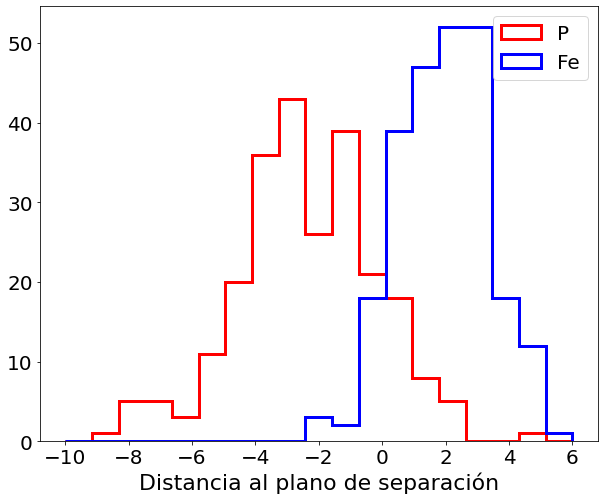

In [393]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [394]:
boostMF(c1_pred, c2_pred)

('1.62', '0.09')

In [395]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,

In [396]:
model_svm_10p = rnd_search_cv.best_estimator_
model_svm_10p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=9.514559499524678, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [397]:
print(accuracy(X_train, y_train, model_svm_10p))
print(crossAccuracy(X_train, y_train, model_svm_10p))

0.9200819672131147
Accuracy:  0.8852891156462587 0.05200085444910047
presicion:  0.8752886510189309 0.06952257651670629
recall:  0.9093333333333333 0.07632241552198875
F1_score:  0.8882126087778437 0.04965184315858327
None


In [398]:
mconfusion(X_train, y_train, model_svm_10p)

Matriz de confusión, 

[[210  34]
 [ 22 222]]
precisión:  0.8671875
exhaustividad:  0.9098360655737705


In [399]:
print(classification_report(y_train, model_svm_10p.predict(X_train)))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       244
           1       0.90      0.95      0.92       244

    accuracy                           0.92       488
   macro avg       0.92      0.92      0.92       488
weighted avg       0.92      0.92      0.92       488



In [400]:
ypred = cross_val_predict(model_svm_10p, X_train, y_train, cv=5, method="decision_function")

In [401]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

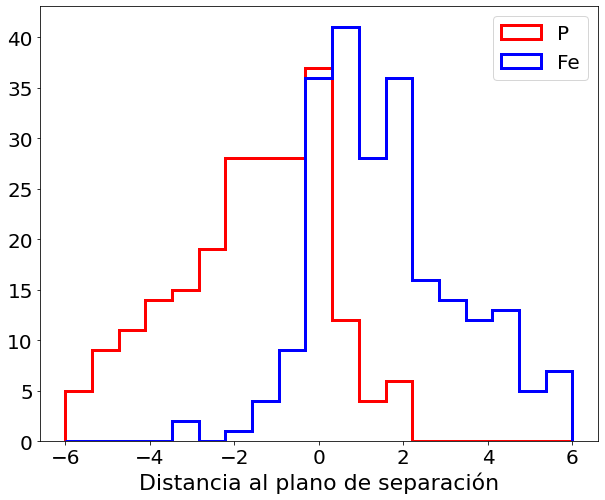

In [402]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [403]:
boostMF(c1_pred, c2_pred)

('1.02', '0.09')

In [404]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.1, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=500, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [405]:
model_svm_11 = rnd_search_cv.best_estimator_
model_svm_11

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=79.80457007951595, break_ties=False, cache_size=200,
                     class_weight=None, coef0=97.40433112393558,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.026031634038459293, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [406]:
print(accuracy(X_train, y_train, model_svm_11))
print(crossAccuracy(X_train, y_train, model_svm_11))

0.9159836065573771
Accuracy:  0.9017431972789115 0.0445980703429486
presicion:  0.8941249567523929 0.06091456479450316
recall:  0.9174999999999999 0.061487351906261555
F1_score:  0.9034582361822425 0.042698903561438975
None


In [407]:
mconfusion(X_train, y_train, model_svm_11)

Matriz de confusión, 

[[216  28]
 [ 20 224]]
precisión:  0.8888888888888888
exhaustividad:  0.9180327868852459


In [408]:
print(classification_report(y_train, model_svm_11.predict(X_train)))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       244
           1       0.90      0.93      0.92       244

    accuracy                           0.92       488
   macro avg       0.92      0.92      0.92       488
weighted avg       0.92      0.92      0.92       488



In [409]:
ypred = cross_val_predict(model_svm_11, X_train, y_train, cv=5, method="decision_function")

In [410]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

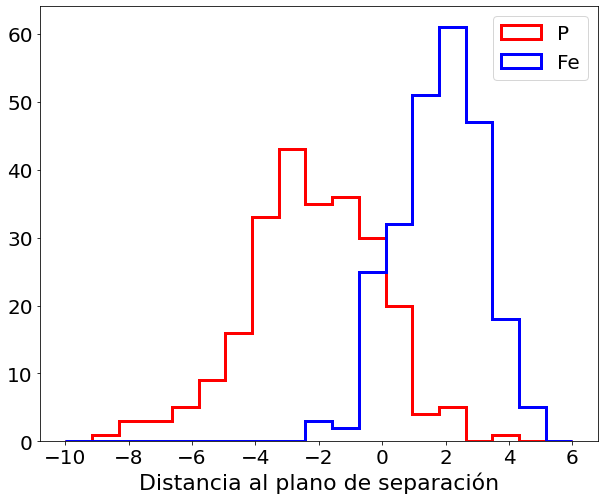

In [411]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [412]:
boostMF(c1_pred, c2_pred)

('1.64', '0.09')